In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import glob
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from asreview import open_state
from asreviewcontrib.insights.plot import plot_recall
from asreviewcontrib.insights.plot import _recall_values
from asreviewcontrib.insights.utils import pad_simulation_labels
import asreviewcontrib.insights.metrics as met
from langdetect import detect
import pylab
import shutil
import os
import string

# Move state files from simulations into state_files folder

In [2]:
path = r'../simulations/state_files' 
if not os.path.exists(path):
    os.makedirs(path)

In [3]:
state_source = "../simulations/prior-knowledge-{}/output/simulation/Hamilton_{}/state_files/sim_Hamilton_{}_{}_{}_0.asreview"
state_target = "../simulations/state_files/pk{}_sim_Hamilton_{}_{}_{}_0.asreview"
prior_knowledge = ['1','2']
classifiers = ['logistic', 'svm']
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'mbert', 'muse', 'mlongt5', 'labse', 'laser', 'mpnet', 'minilm', 'stsb']

In [4]:
for prior in prior_knowledge:
    for classifier in classifiers:
        for dataset in datasets:
            for model in models:
                source = state_source.format(prior, dataset, dataset, classifier, model)
                target = state_target.format(prior, dataset, classifier, model)
                if (os.path.exists(source)) & (not os.path.exists(target)):
                    shutil.copy(source, target)

# Extract statefiles into df

In [5]:
metrics_df = pd.DataFrame()
for prior in prior_knowledge:
    for classifier in classifiers:
        for dataset in datasets:
            for model in models:
                row = {'Dataset':dataset, 'Classifier':classifier, 'Model':model, 'Prior':prior}
                with open_state(state_target.format(prior, dataset, classifier, model)) as state:
                    metrics = met.get_metrics(state)
                    for item in metrics['data']['items']:
                        if item.get('title') == 'Time to discovery':
                            for paper_td in item.get('value'):
                                if paper_td[0] in [300, 567, 741, 878, 1112]:
                                    row['td_'+str(paper_td[0])] = paper_td[1]
                        elif type(item.get('value')) != list:
                            row[item.get('title')] = item.get('value')
                        else:
                            for value in item.get('value'):
                                row[str(item.get('title'))+'_'+str(value[0])] = value[1]
                metrics_df = metrics_df.append(row, ignore_index = True)
metrics_df = metrics_df.rename(columns={"Average time to discovery": "ATD", "Work Saved over Sampling_0.95": "WSS@95"})
metrics_df['ctd_targets'] = metrics_df['td_300'] + metrics_df['td_567'] + metrics_df['td_741'] + metrics_df['td_878'] + metrics_df['td_1112']
metrics_df

,ATD,Classifier,Dataset,Extra Relevant record Found_0.1,Model,Prior,Recall_0.1,Recall_0.25,Recall_0.5,Recall_0.75,Recall_0.9,WSS@95,td_1112,td_300,td_567,td_741,td_878,ctd_targets
0,144.593023,logistic,Original,0.674419,tfidf,1,0.779070,0.930233,1.000000,1.000000,1.0,0.639203,691.0,585.0,581.0,246.0,263.0,2366.0
1,114.558140,logistic,Original,0.779070,sbert,1,0.883721,0.965116,0.988372,1.000000,1.0,0.819602,731.0,1091.0,60.0,63.0,81.0,2026.0
2,229.337209,logistic,Original,0.465116,mbert,1,0.569767,0.872093,0.988372,0.988372,1.0,0.603662,312.0,489.0,199.0,304.0,302.0,1606.0
3,114.860465,logistic,Original,0.709302,muse,1,0.813953,0.976744,1.000000,1.000000,1.0,0.780291,69.0,438.0,19.0,87.0,64.0,677.0
4,239.383721,logistic,Original,0.372093,mlongt5,1,0.476744,0.872093,1.000000,1.000000,1.0,0.623048,94.0,247.0,52.0,27.0,31.0,451.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156.011628,svm,Multi_2,0.604651,labse,2,0.709302,0.930233,1.000000,1.000000,1.0,0.682822,629.0,598.0,36.0,7.0,25.0,1295.0
156,241.209302,svm,Multi_2,0.453488,laser,2,0.558140,0.837209,0.988372,0.988372,1.0,0.613355,468.0,899.0,235.0,18.0,25.0,1645.0
157,216.534884,svm,Multi_2,0.534884,mpnet,2,0.639535,0.883721,0.965116,0.988372,1.0,0.513732,565.0,1447.0,785.0,25.0,82.0,2904.0
158,274.186047,svm,Multi_2,0.372093,minilm,2,0.476744,0.825581,0.941860,0.976744,1.0,0.488422,832.0,1394.0,1479.0,30.0,204.0,3939.0


In [6]:
#metrics_df.to_csv("metrics.csv")

# Tables

In [15]:
#All simulations
sim = metrics_df
sim[['Model', 'Dataset', 'Classifier', 'Prior', 
        'Recall_0.1', 'WSS@95', 
        'ATD', 'td_1112', 'td_300', 'td_567', 'td_741', 'td_878']].round(2)

,Model,Dataset,Classifier,Prior,Recall_0.1,WSS@95,ATD,td_1112,td_300,td_567,td_741,td_878
0,tfidf,Original,logistic,1,0.78,0.64,144.59,691.0,585.0,581.0,246.0,263.0
1,sbert,Original,logistic,1,0.88,0.82,114.56,731.0,1091.0,60.0,63.0,81.0
2,mbert,Original,logistic,1,0.57,0.60,229.34,312.0,489.0,199.0,304.0,302.0
3,muse,Original,logistic,1,0.81,0.78,114.86,69.0,438.0,19.0,87.0,64.0
4,mlongt5,Original,logistic,1,0.48,0.62,239.38,94.0,247.0,52.0,27.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
155,labse,Multi_2,svm,2,0.71,0.68,156.01,629.0,598.0,36.0,7.0,25.0
156,laser,Multi_2,svm,2,0.56,0.61,241.21,468.0,899.0,235.0,18.0,25.0
157,mpnet,Multi_2,svm,2,0.64,0.51,216.53,565.0,1447.0,785.0,25.0,82.0
158,minilm,Multi_2,svm,2,0.48,0.49,274.19,832.0,1394.0,1479.0,30.0,204.0


In [16]:
#Specific simulations
sim = metrics_df.loc[(metrics_df.Classifier == 'logistic') & (metrics_df.Prior == '1') & (metrics_df.Dataset == 'Multi_2')]
sim[['Model', 'Dataset', 'Classifier', 'Prior', 
        'Recall_0.1', 'WSS@95', 
        'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets']].round(2)

,Model,Dataset,Classifier,Prior,Recall_0.1,WSS@95,ATD,td_300,td_567,td_741,td_878,td_1112,ctd_targets
30,tfidf,Multi_2,logistic,1,0.74,0.52,198.88,1552.0,1557.0,1073.0,1445.0,1853.0,7480.0
31,sbert,Multi_2,logistic,1,0.86,0.80,123.84,912.0,835.0,100.0,223.0,772.0,2842.0
32,mbert,Multi_2,logistic,1,0.52,0.58,258.31,689.0,574.0,317.0,583.0,664.0,2827.0
33,muse,Multi_2,logistic,1,0.81,0.78,117.38,564.0,29.0,113.0,66.0,167.0,939.0
34,mlongt5,Multi_2,logistic,1,0.45,0.62,248.41,371.0,250.0,95.0,157.0,347.0,1220.0
35,labse,Multi_2,logistic,1,0.72,0.67,141.01,551.0,40.0,20.0,34.0,515.0,1160.0
36,laser,Multi_2,logistic,1,0.57,0.64,220.69,640.0,108.0,217.0,137.0,250.0,1352.0
37,mpnet,Multi_2,logistic,1,0.55,0.63,215.74,1289.0,598.0,38.0,443.0,498.0,2866.0
38,minilm,Multi_2,logistic,1,0.55,0.62,236.97,1248.0,1331.0,65.0,588.0,729.0,3961.0
39,stsb,Multi_2,logistic,1,0.50,0.58,247.37,661.0,578.0,60.0,200.0,653.0,2152.0


In [17]:
#Average grouped by dataset
sim = metrics_df
sim.groupby(['Dataset'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)

<ipython-input-17-cd6cd886a933>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sim.groupby(['Dataset'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)


,Recall_0.1,WSS@95,ATD,td_300,td_567,td_741,td_878,td_1112,ctd_targets
Dataset,,,,,,,,,
English,0.63,0.67,190.64,628.50,156.78,107.12,156.15,309.10,1357.65
Multi_1,0.61,0.64,205.40,844.25,434.12,202.15,383.48,634.78,2498.78
Multi_2,0.62,0.62,206.17,846.20,601.62,207.38,349.85,630.17,2635.22
Original,0.63,0.66,195.43,770.62,224.92,129.40,164.28,510.12,1799.35


In [18]:
#Average grouped by dataset and classifier
sim = metrics_df
sim.groupby(['Dataset', 'Classifier'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)

<ipython-input-18-27e58fcd4678>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sim.groupby(['Dataset', 'Classifier'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)


Recall_0.1  WSS@95     ATD  td_300  td_567  td_741  \
Dataset  Classifier                                                       
English  logistic          0.63    0.68  189.31  591.35  153.70   85.20   
         svm               0.63    0.65  191.97  665.65  159.85  129.05   
Multi_1  logistic          0.61    0.65  203.94  814.80  440.90  184.50   
         svm               0.62    0.62  206.86  873.70  427.35  219.80   
Multi_2  logistic          0.62    0.64  203.27  834.55  618.10  194.05   
         svm               0.62    0.61  209.06  857.85  585.15  220.70   
Original logistic          0.63    0.67  192.43  722.00  222.15  106.95   
         svm               0.63    0.65  198.44  819.25  227.70  151.85   

                     td_878  td_1112  ctd_targets  
Dataset  Classifier                                
English  logistic    169.80   288.10      1288.15  
         svm         142.50   330.10      1427.15  
Multi_1  logistic    374.05   620.15      2434.40  
         svm         392.90   649.40      2563.15  
Multi_2  logistic    374.90   643.80      2665.40  
         svm         324.80   616.55      2605.05  
Original logistic    163.10   486.50      1700.70  
         svm         165.45   533.75      1898.00

In [19]:
#Average grouped by dataset and prior knowledge
sim = metrics_df
sim.groupby(['Dataset', 'Prior'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)

<ipython-input-19-64fb1ff2d644>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sim.groupby(['Dataset', 'Prior'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)


Recall_0.1  WSS@95     ATD  td_300  td_567  td_741  td_878  \
Dataset  Prior                                                               
English  1            0.64    0.67  186.18  627.20  178.50  133.45  160.65   
         2            0.62    0.66  195.09  629.80  135.05   80.80  151.65   
Multi_1  1            0.62    0.64  201.93  831.65  419.65  207.90  387.85   
         2            0.61    0.63  208.87  856.85  448.60  196.40  379.10   
Multi_2  1            0.62    0.63  204.39  854.85  571.55  231.40  364.95   
         2            0.62    0.61  207.94  837.55  631.70  183.35  334.75   
Original 1            0.63    0.66  193.99  756.55  219.15  146.00  163.00   
         2            0.62    0.66  196.88  784.70  230.70  112.80  165.55   

                td_1112  ctd_targets  
Dataset  Prior                        
English  1       309.80      1409.60  
         2       308.40      1305.70  
Multi_1  1       614.95      2462.00  
         2       654.60      2535.55  
Multi_2  1       616.20      2638.95  
         2       644.15      2631.50  
Original 1       505.00      1789.70  
         2       515.25      1809.00

In [20]:
#Average grouped by dataset and model
sim = metrics_df
sim.groupby(['Dataset', 'Model'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)

<ipython-input-20-cb6b7aa0ffb9>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sim.groupby(['Dataset', 'Model'])['Recall_0.1', 'WSS@95', 'ATD', 'td_300', 'td_567', 'td_741', 'td_878', 'td_1112', 'ctd_targets'].mean().round(2)


Recall_0.1  WSS@95     ATD   td_300   td_567   td_741  \
Dataset  Model                                                            
English  labse          0.73    0.74  143.13   459.75    80.00    98.75   
         laser          0.56    0.61  233.78   668.75   242.25    85.50   
         mbert          0.55    0.59  241.79   824.75   156.75   122.50   
         minilm         0.55    0.64  225.14   564.25   167.25    58.50   
         mlongt5        0.48    0.64  237.56   164.50   119.00   188.75   
         mpnet          0.61    0.64  195.92   887.25   100.75    39.50   
         muse           0.74    0.70  147.28   686.25   111.75   145.25   
         sbert          0.84    0.81  112.36   911.00    60.25    54.50   
         stsb           0.49    0.64  229.33   403.00   353.25    95.75   
         tfidf          0.77    0.68  140.06   715.50   176.50   182.25   
Multi_1  labse          0.72    0.73  142.49   512.50   110.50    16.25   
         laser          0.55    0.60  230.77   769.25   162.75   142.00   
         mbert          0.52    0.57  256.15   305.25   136.75   244.50   
         minilm         0.51    0.62  241.98  1311.50   414.75    53.25   
         mlongt5        0.44    0.63  247.83   348.25   345.75   112.50   
         mpnet          0.57    0.63  214.56  1495.25   349.00    36.75   
         muse           0.74    0.70  150.29   712.00    77.50    69.50   
         sbert          0.84    0.79  129.41   896.00   893.25    87.25   
         stsb           0.50    0.61  234.91   607.25   365.75    93.00   
         tfidf          0.75    0.47  205.62  1485.25  1485.25  1166.50   
Multi_2  labse          0.70    0.69  148.62   524.50    33.00    18.25   
         laser          0.55    0.62  232.44   814.25   194.25   138.25   
         mbert          0.54    0.57  261.73   762.25   538.00   350.50   
         minilm         0.51    0.58  254.89  1292.25  1404.50    60.50   
         mlongt5        0.48    0.62  233.49   307.25   230.75    76.00   
         mpnet          0.61    0.59  213.81  1411.50   705.00    54.25   
         muse           0.72    0.71  152.14   491.50   124.25    86.25   
         sbert          0.84    0.80  124.35   816.25   646.75    75.25   
         stsb           0.53    0.58  233.29   538.75   635.50    77.00   
         tfidf          0.74    0.47  206.90  1503.50  1504.25  1137.50   
Original labse          0.72    0.72  146.97   549.25    86.50    46.00   
         laser          0.56    0.62  228.46   886.00   248.25   225.50   
         mbert          0.54    0.62  235.43   447.00   255.00   327.00   
         minilm         0.56    0.62  236.08  1286.50   160.00    59.75   
         mlongt5        0.48    0.63  233.56   243.00    78.50    25.75   
         mpnet          0.58    0.63  210.81  1417.00   192.50    65.25   
         muse           0.74    0.72  149.18   605.75    64.00    69.25   
         sbert          0.85    0.81  120.12  1037.25    92.25    63.50   
         stsb           0.49    0.61  239.36   539.25   380.50   130.00   
         tfidf          0.75    0.64  154.37   695.25   691.75   282.00   

                   td_878  td_1112  ctd_targets  
Dataset  Model                                   
English  labse      35.75   421.00      1095.25  
         laser      75.50   443.00      1515.00  
         mbert     136.00   581.25      1821.25  
         minilm    338.75   481.75      1610.50  
         mlongt5   140.25    68.75       681.25  
         mpnet     258.75   169.75      1456.00  
         muse      150.50   121.25      1215.00  
         sbert      54.75   254.25      1334.75  
         stsb      311.50   296.25      1459.75  
         tfidf      59.75   253.75      1387.75  
Multi_1  labse      41.25   464.00      1144.50  
         laser      84.25   428.25      1586.50  
         mbert     643.50   349.50      1679.50  
         minilm    315.50   888.00      2983.00  
         mlongt5   131.75   261.00      1199.25  
         mpnet   

## Recall Plots

In [21]:
#Define language for each paper abstract, this could take up to 1 minute
csv_file = "../simulations/prior-knowledge-1/data/Hamilton_{}.csv"
language_dfs = {}
for dataset in datasets:
    languages = pd.read_csv(csv_file.format(dataset))
    languages['language'] = languages['abstract'].dropna().apply(detect)
    languages.columns.values[0] = 'record_id'
    language_dfs[dataset] = languages

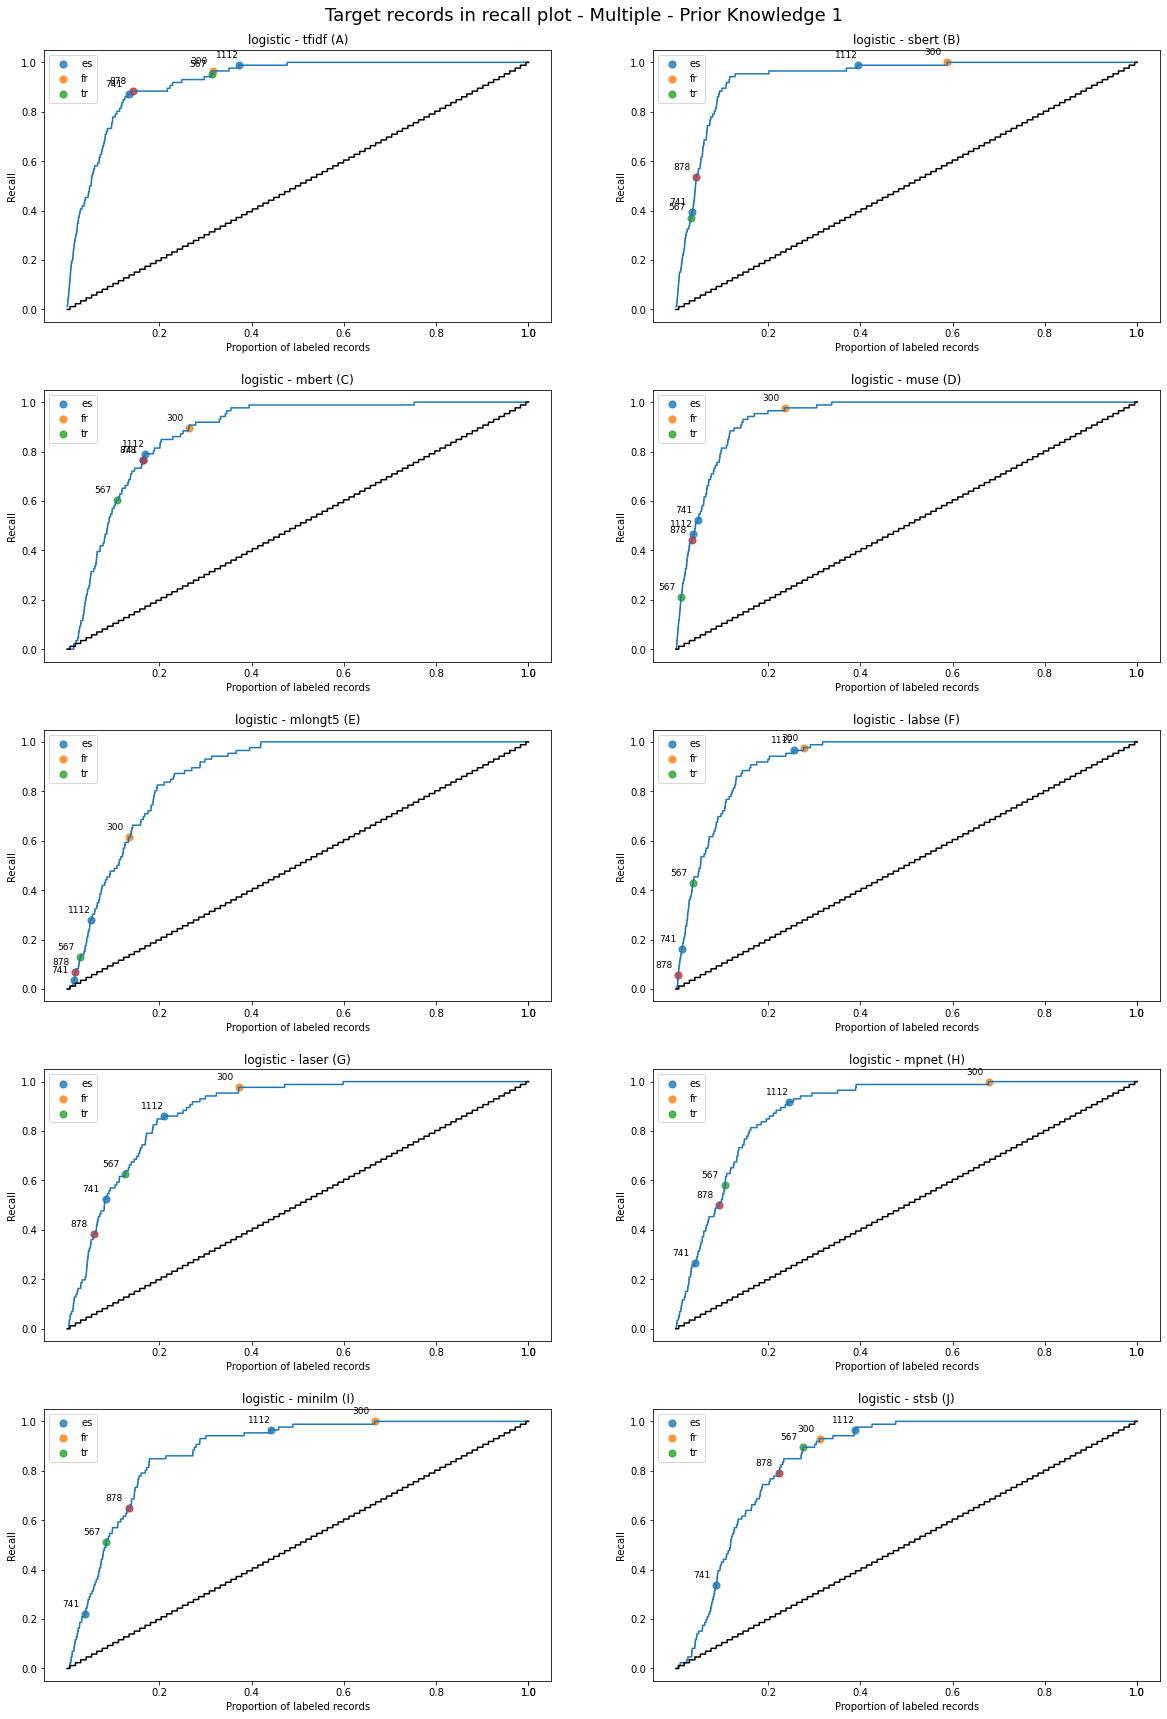

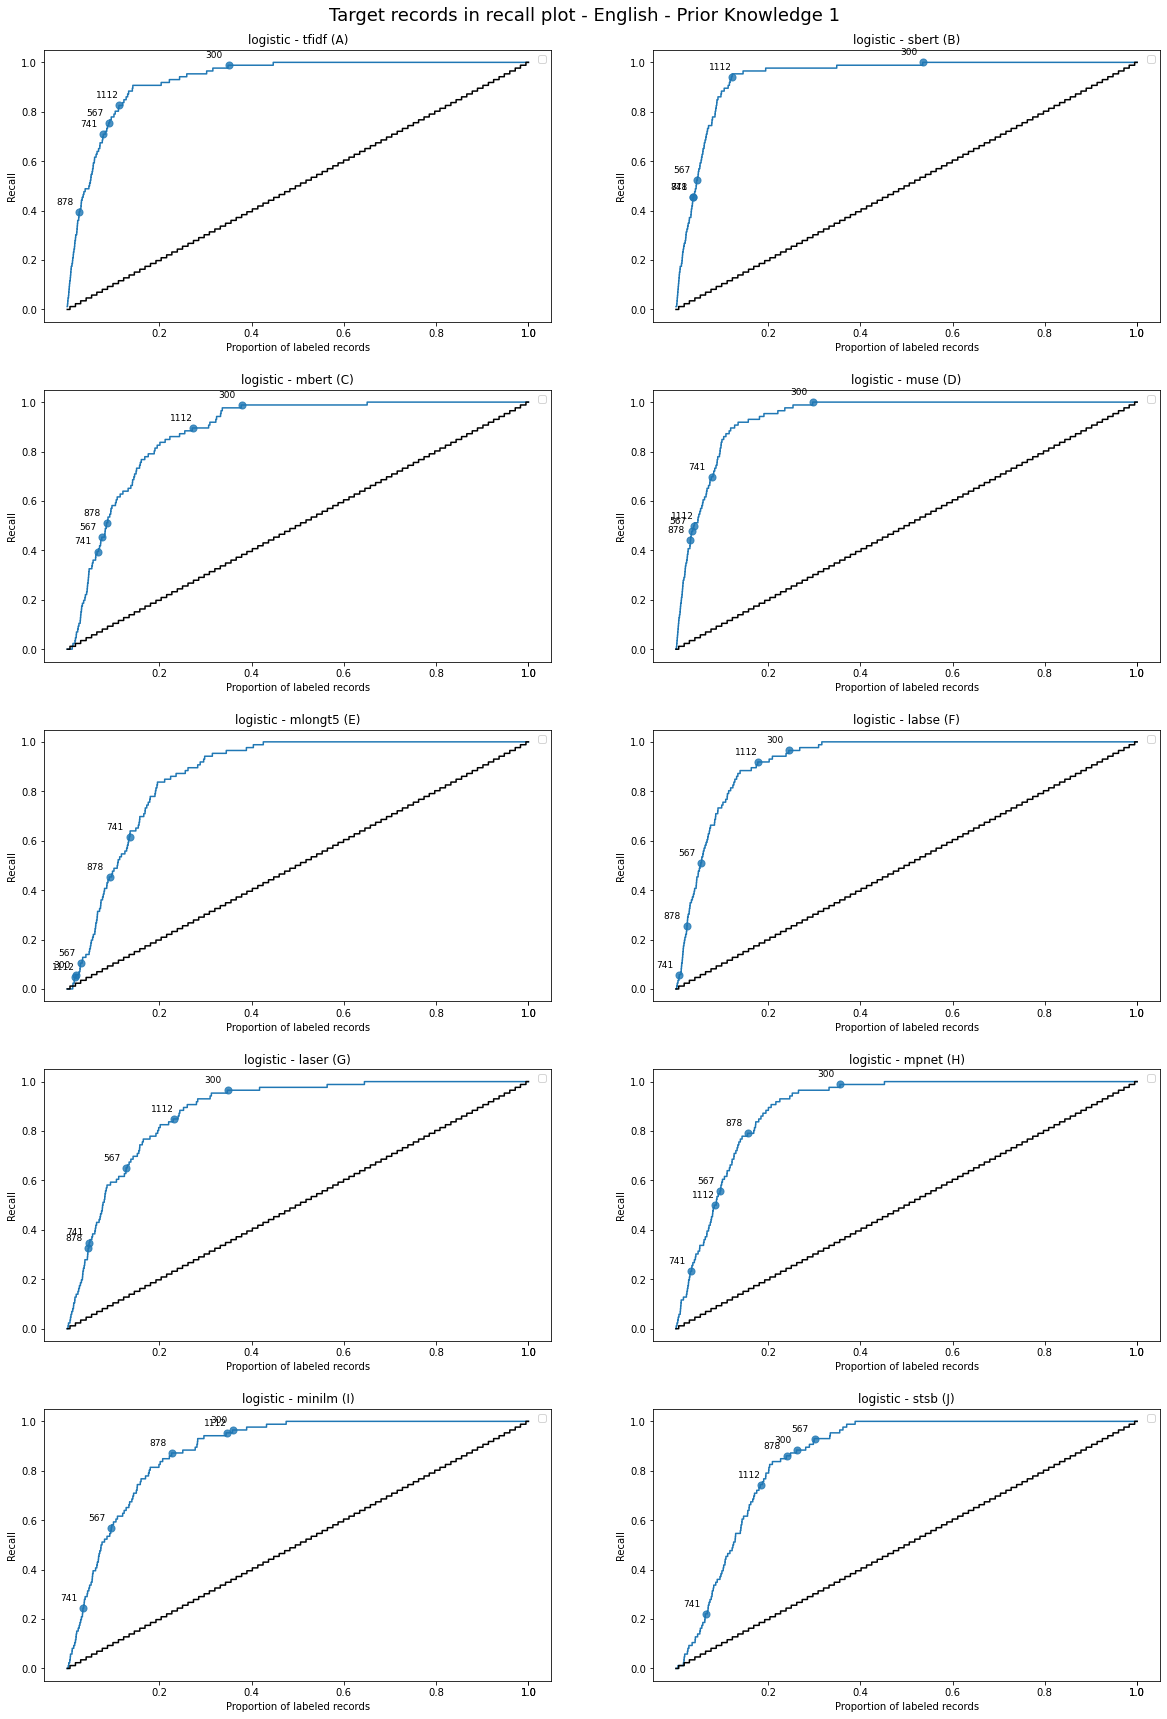

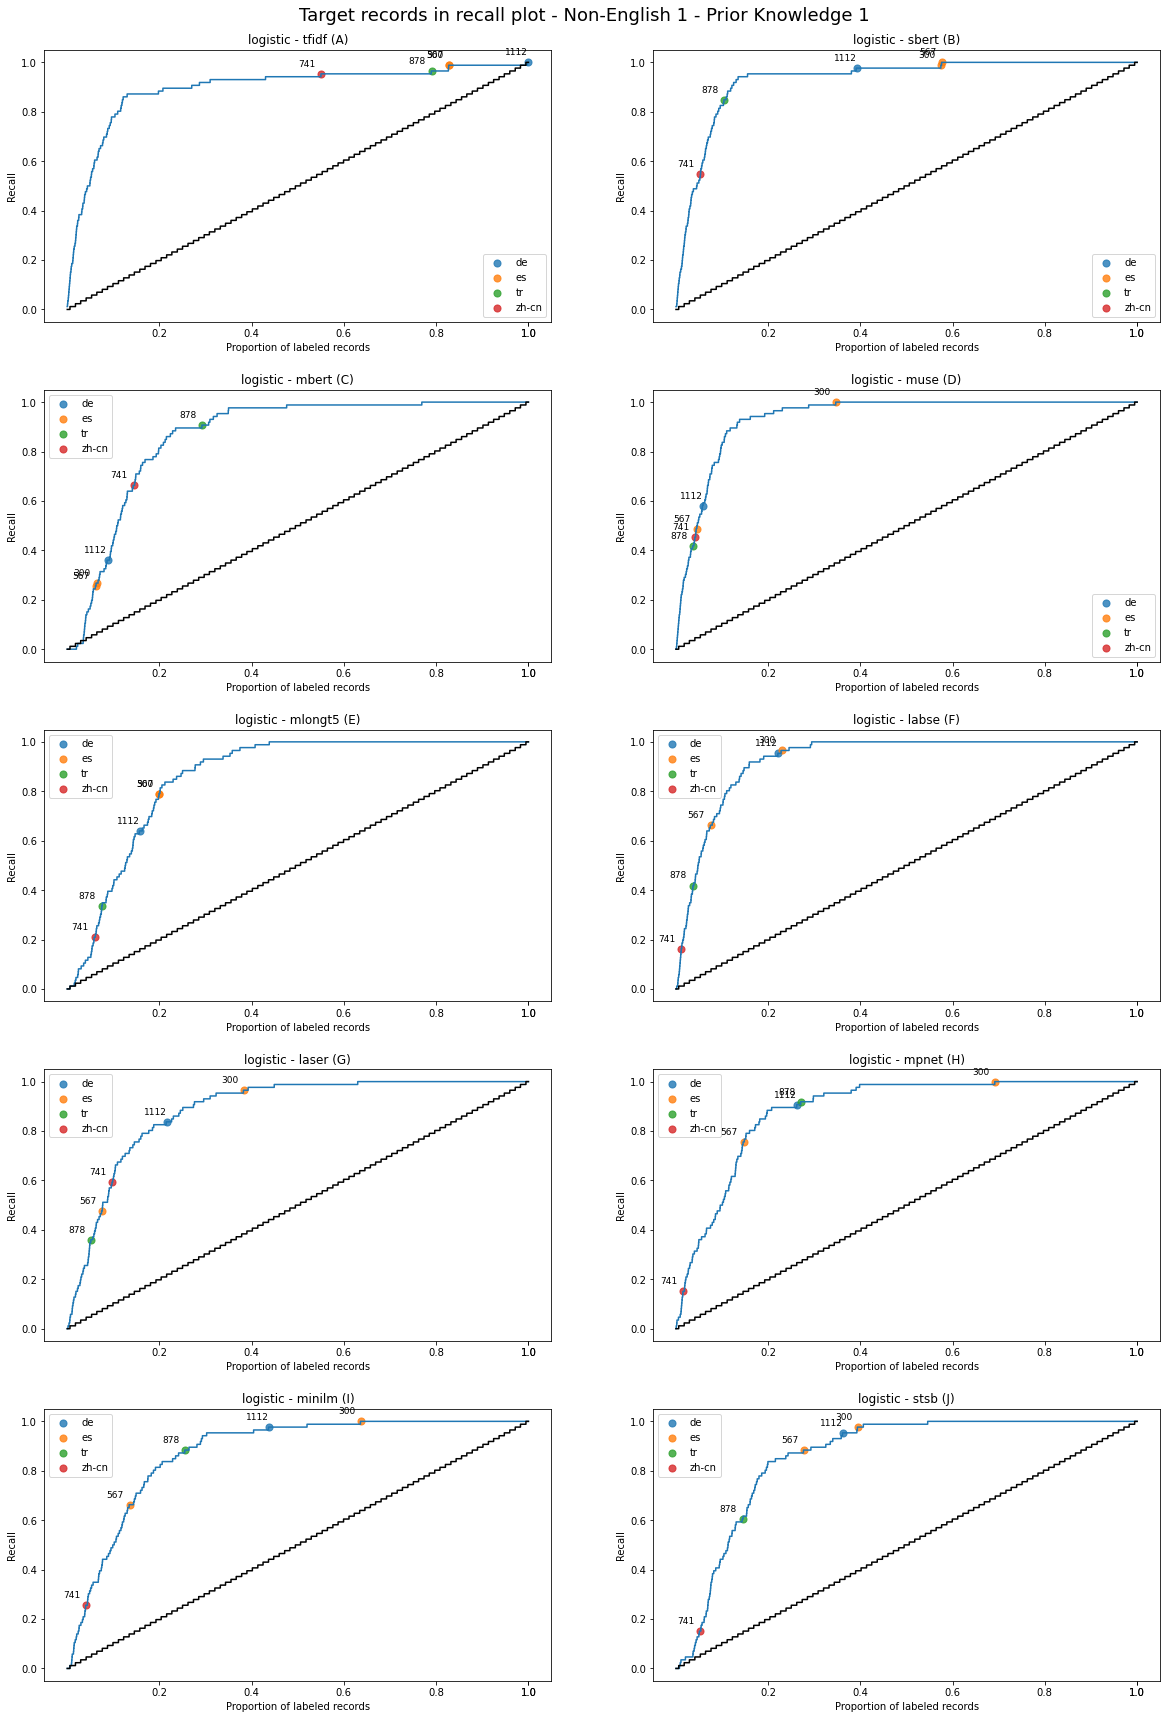

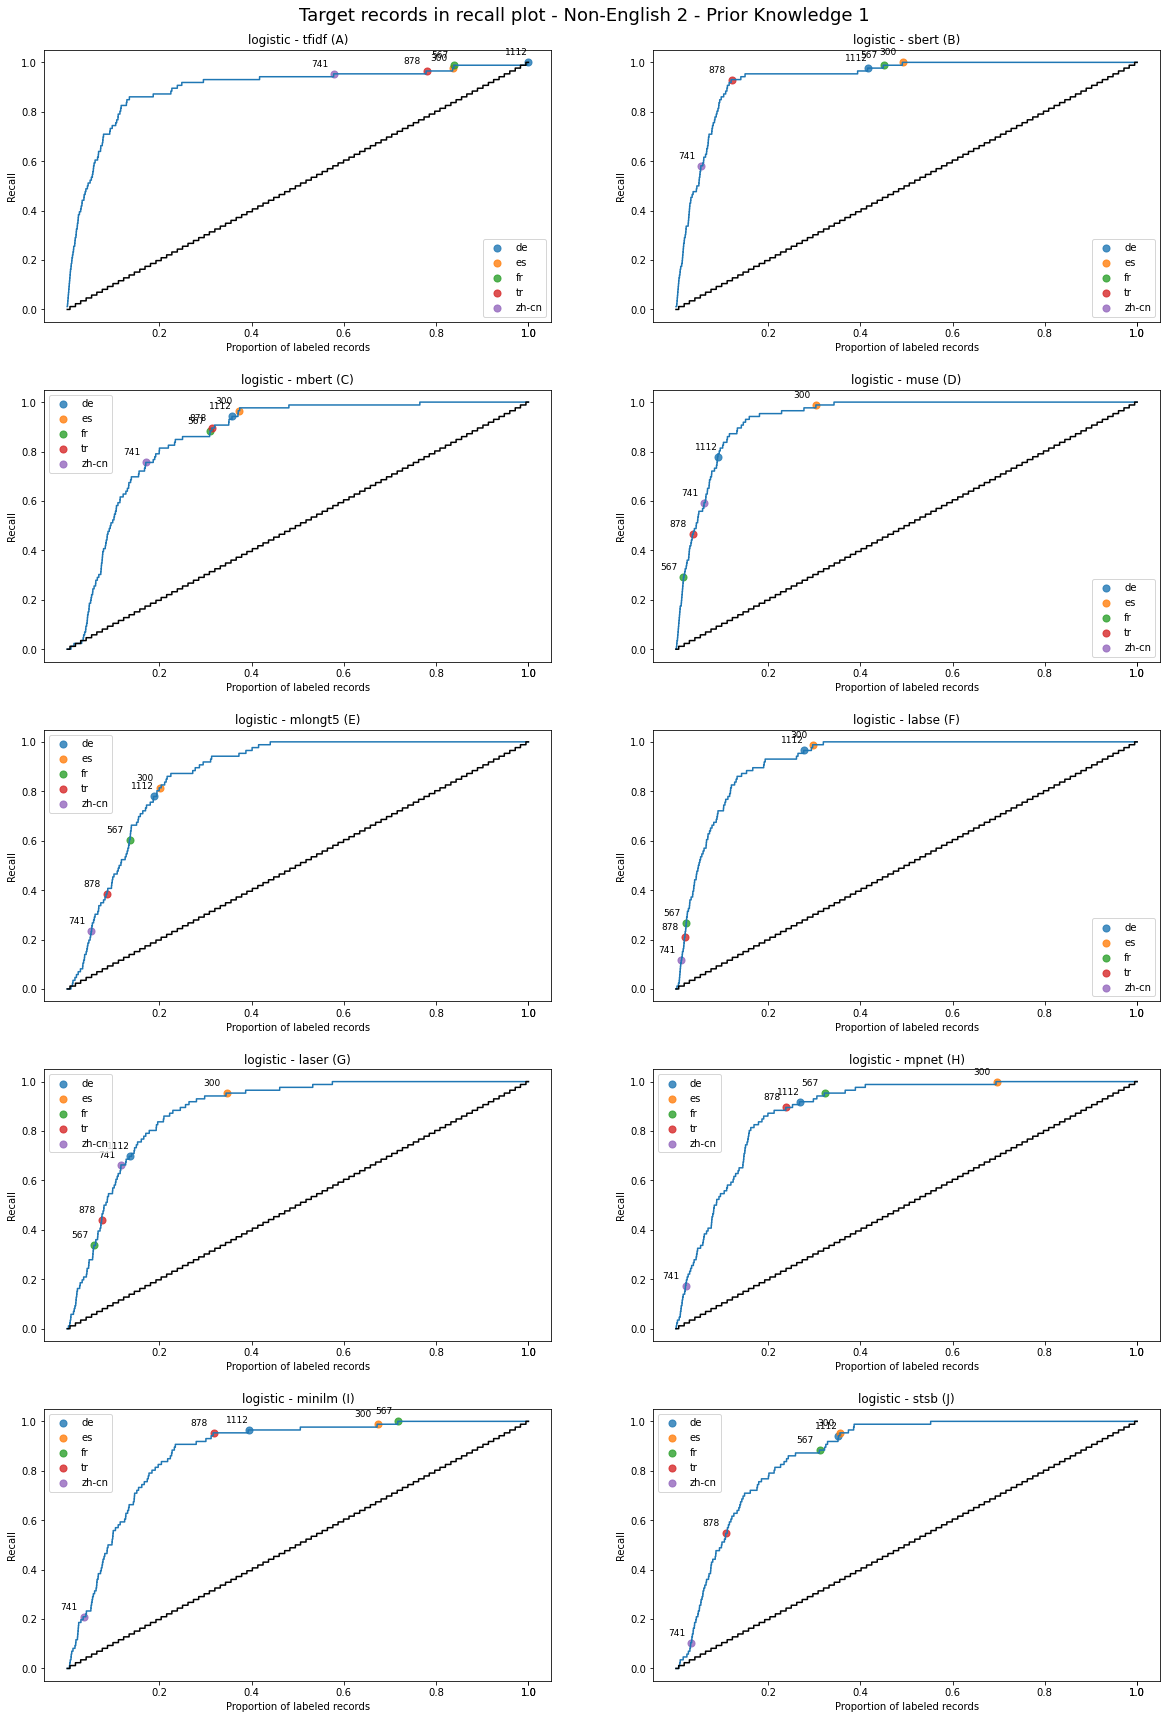

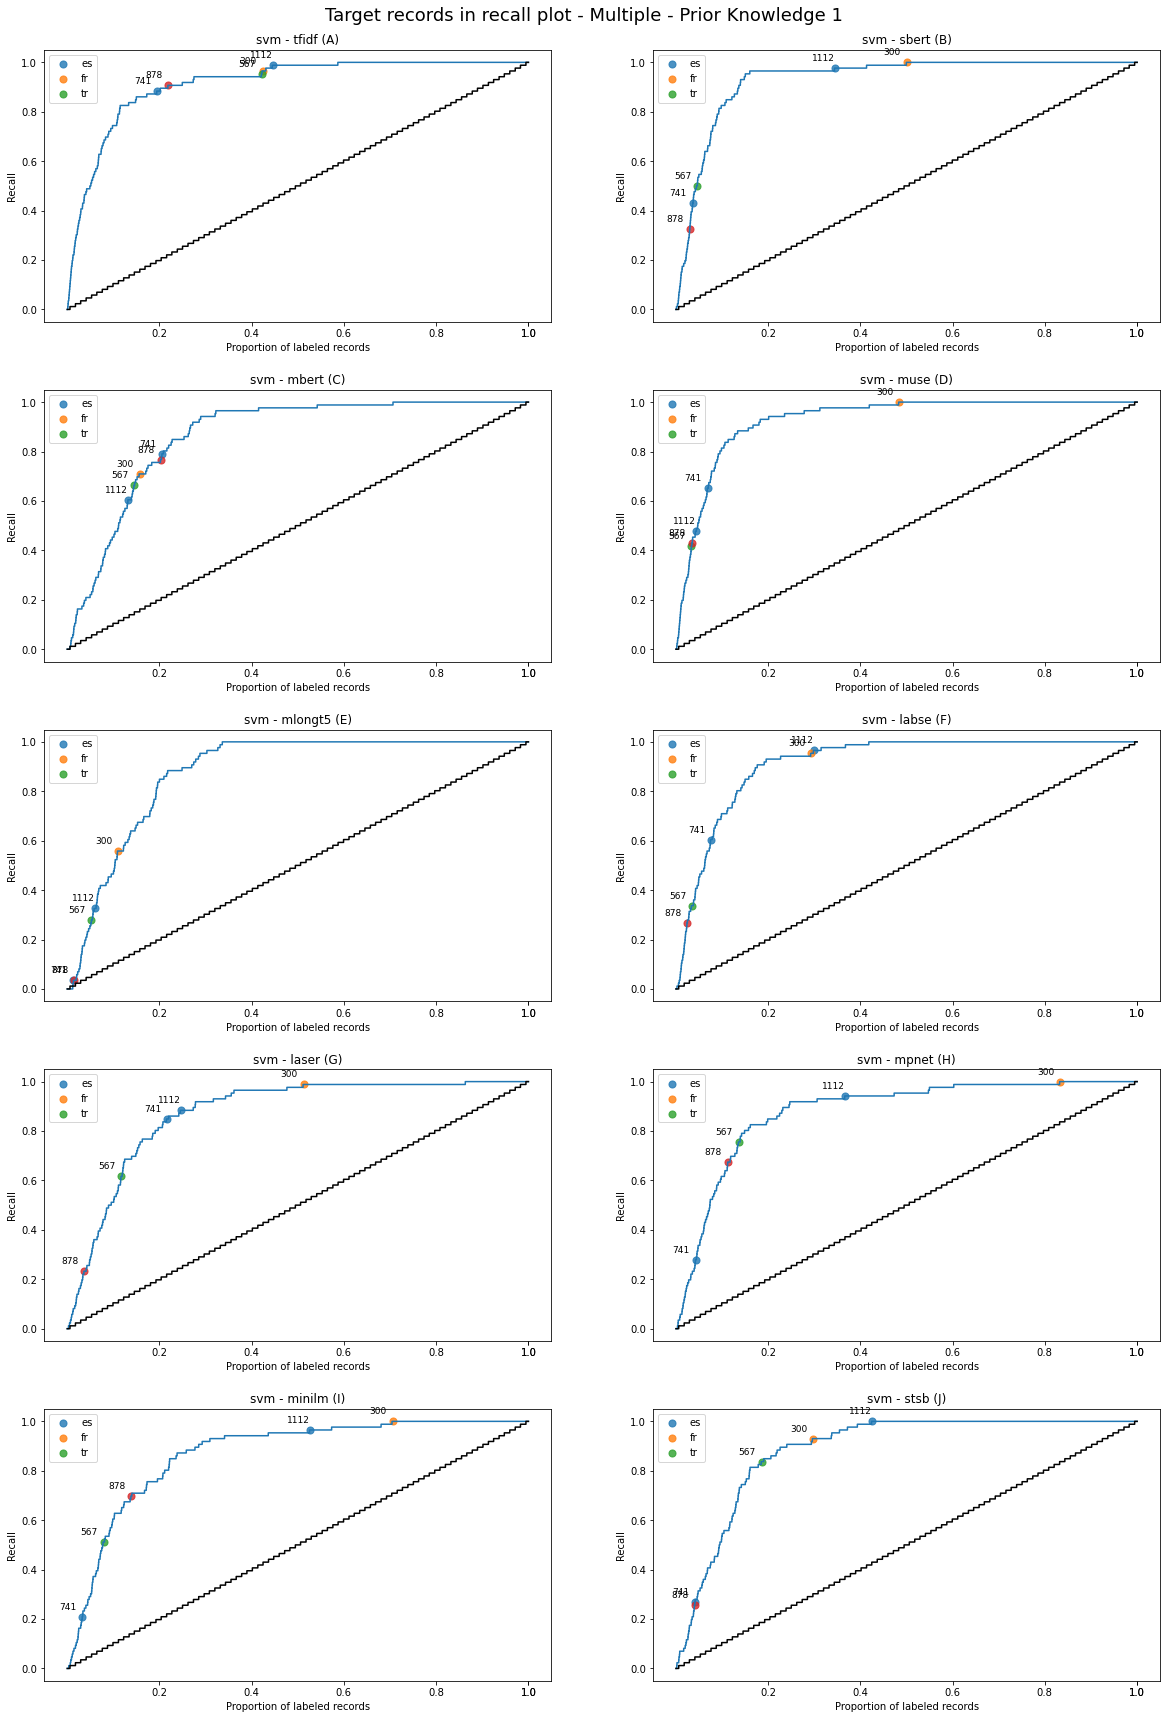

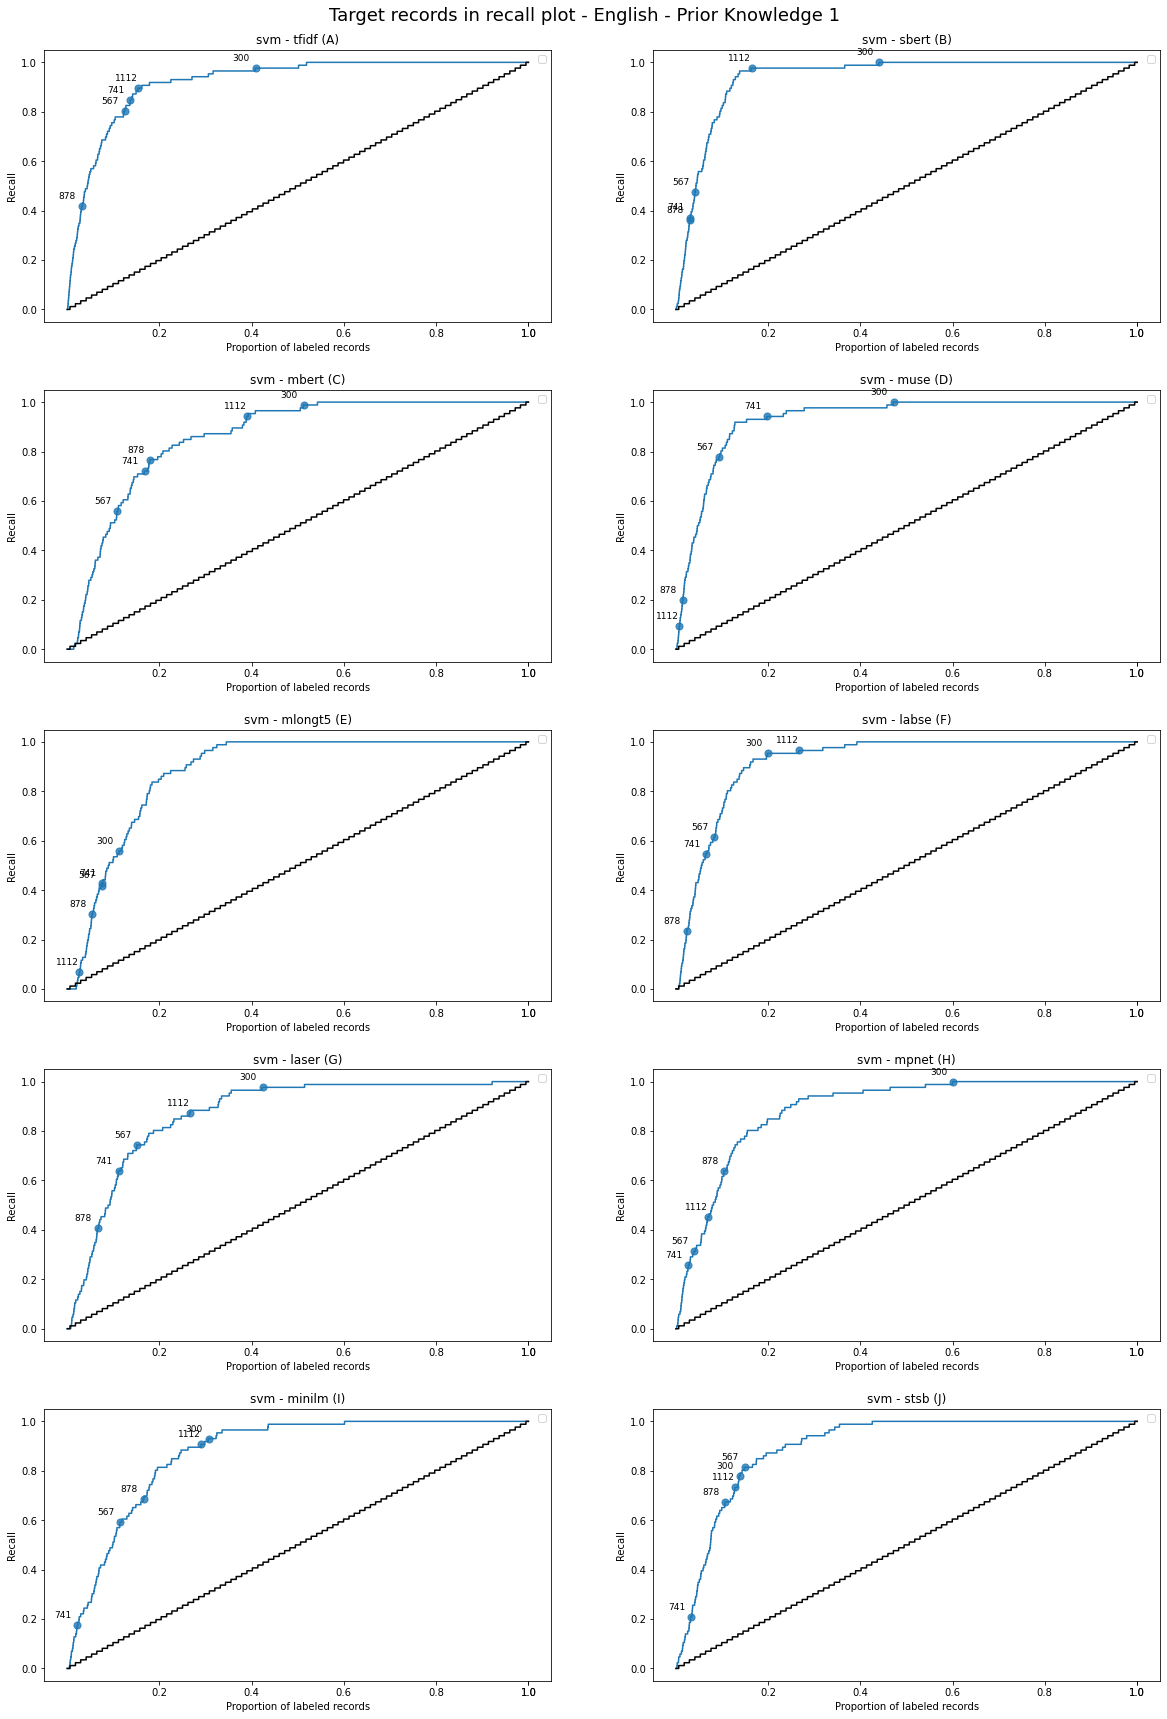

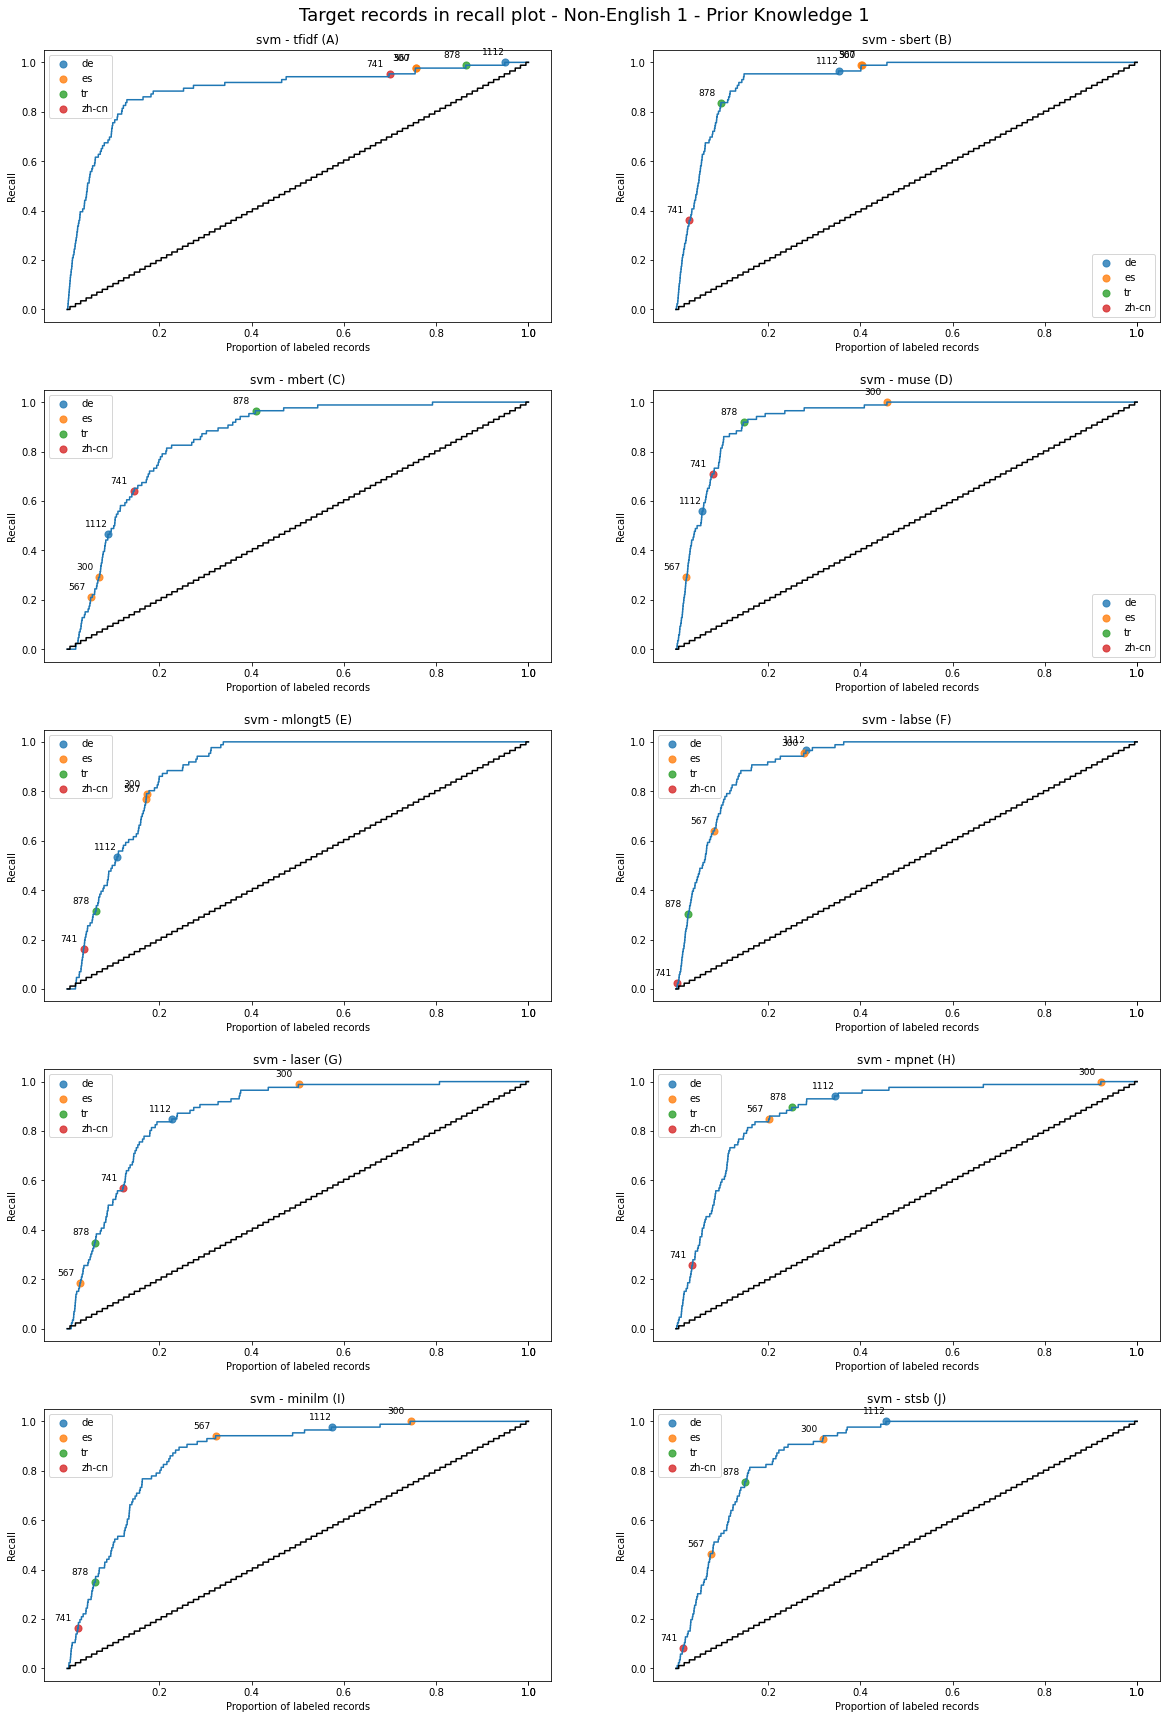

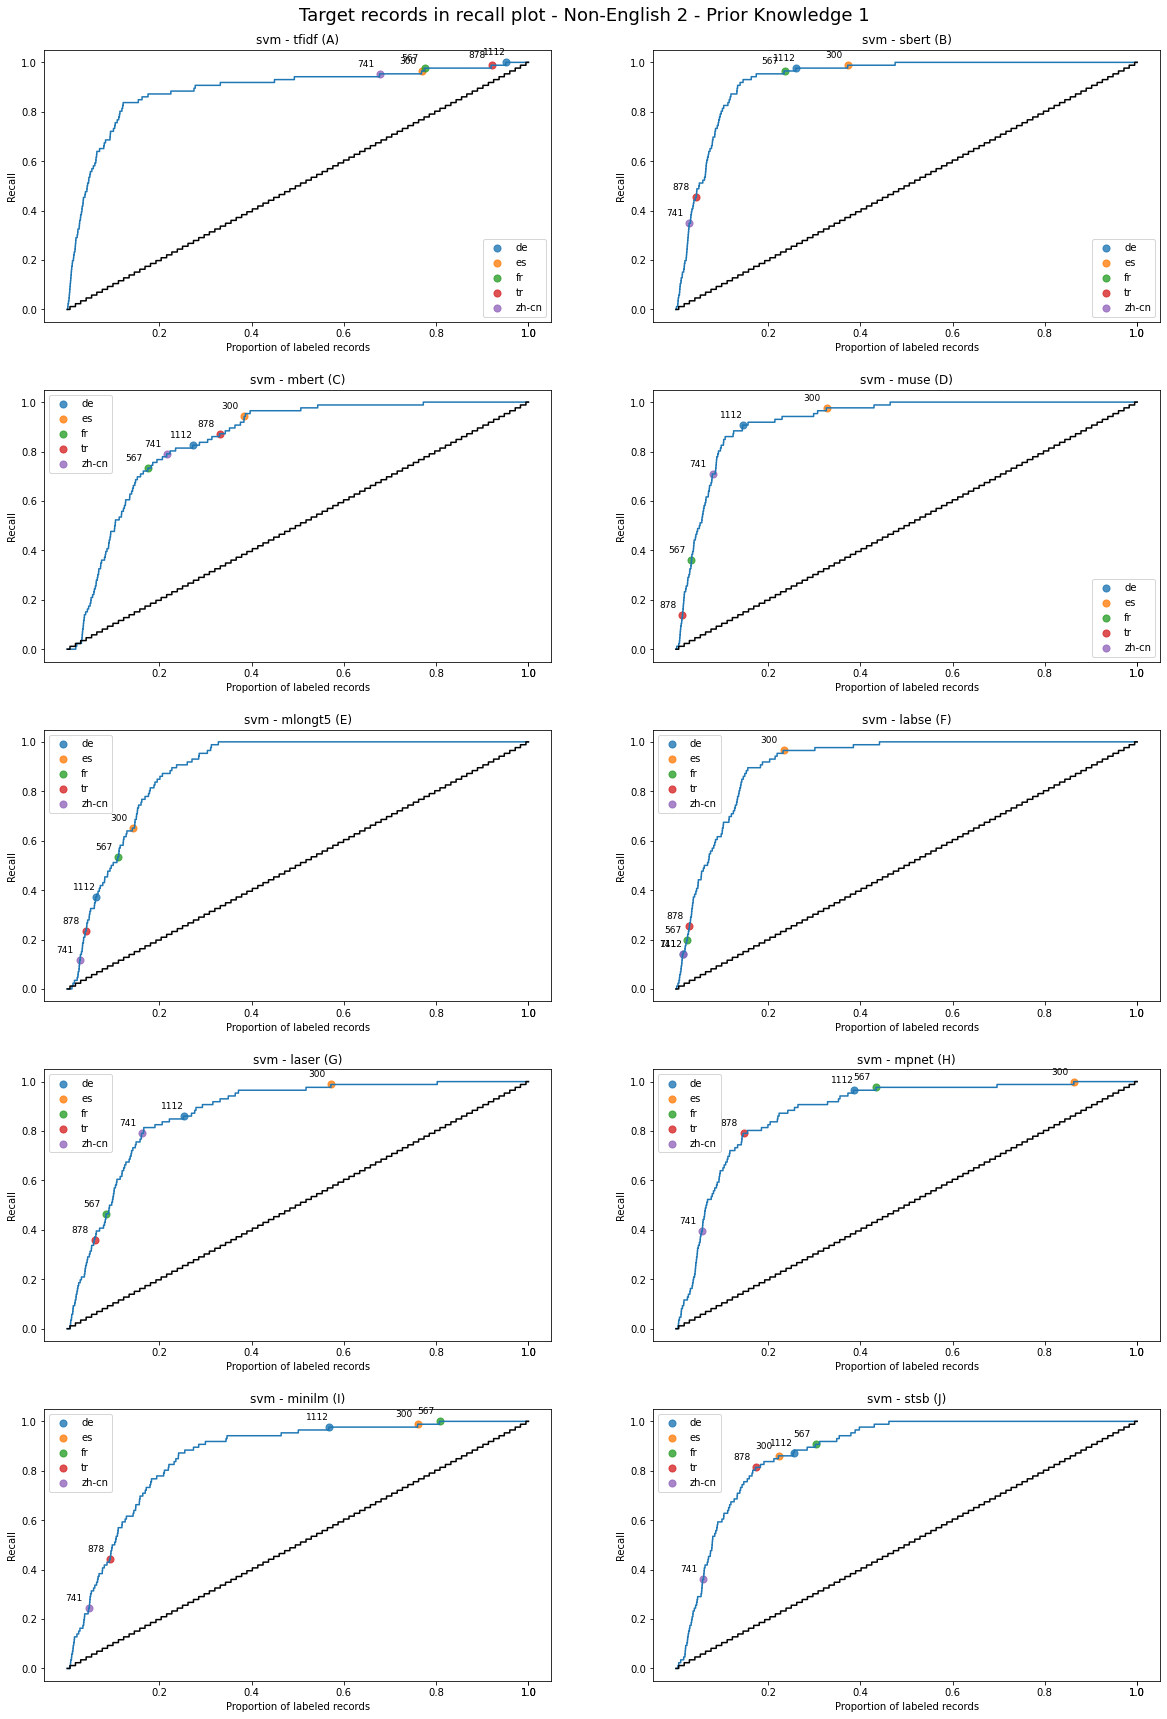

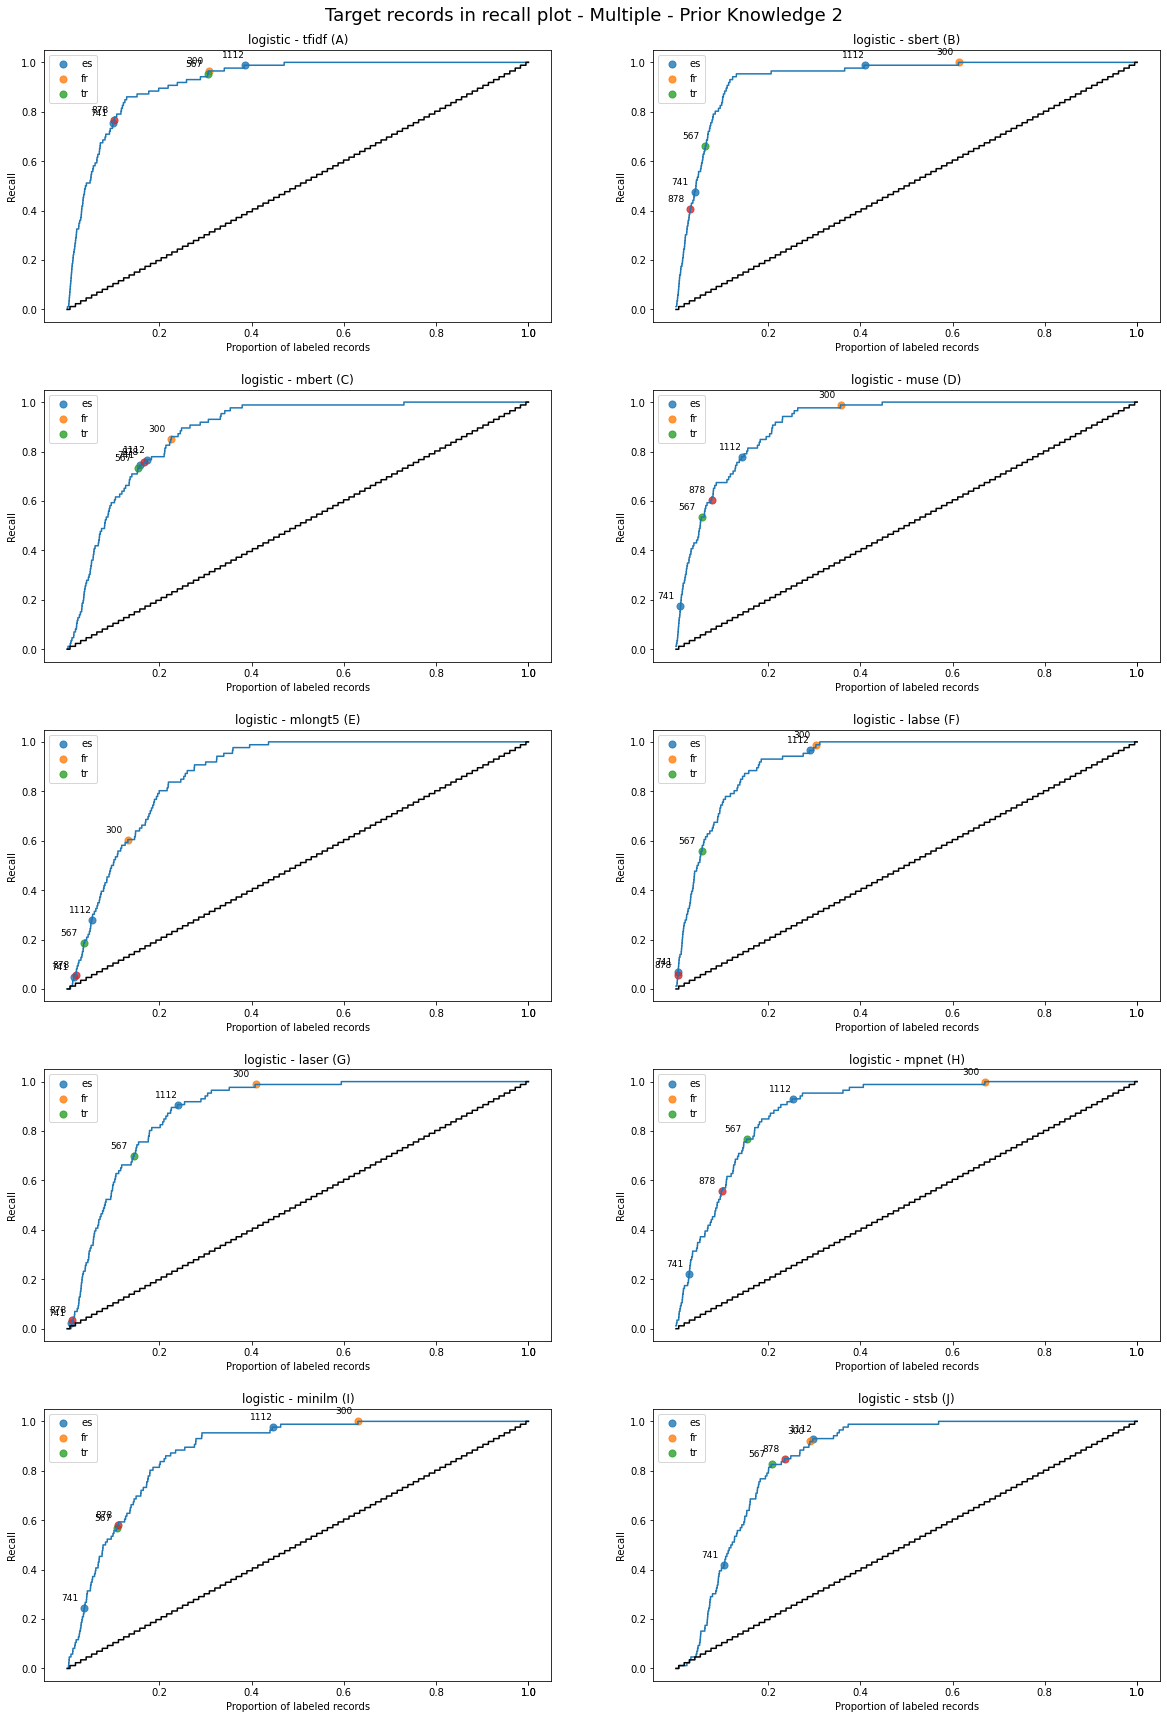

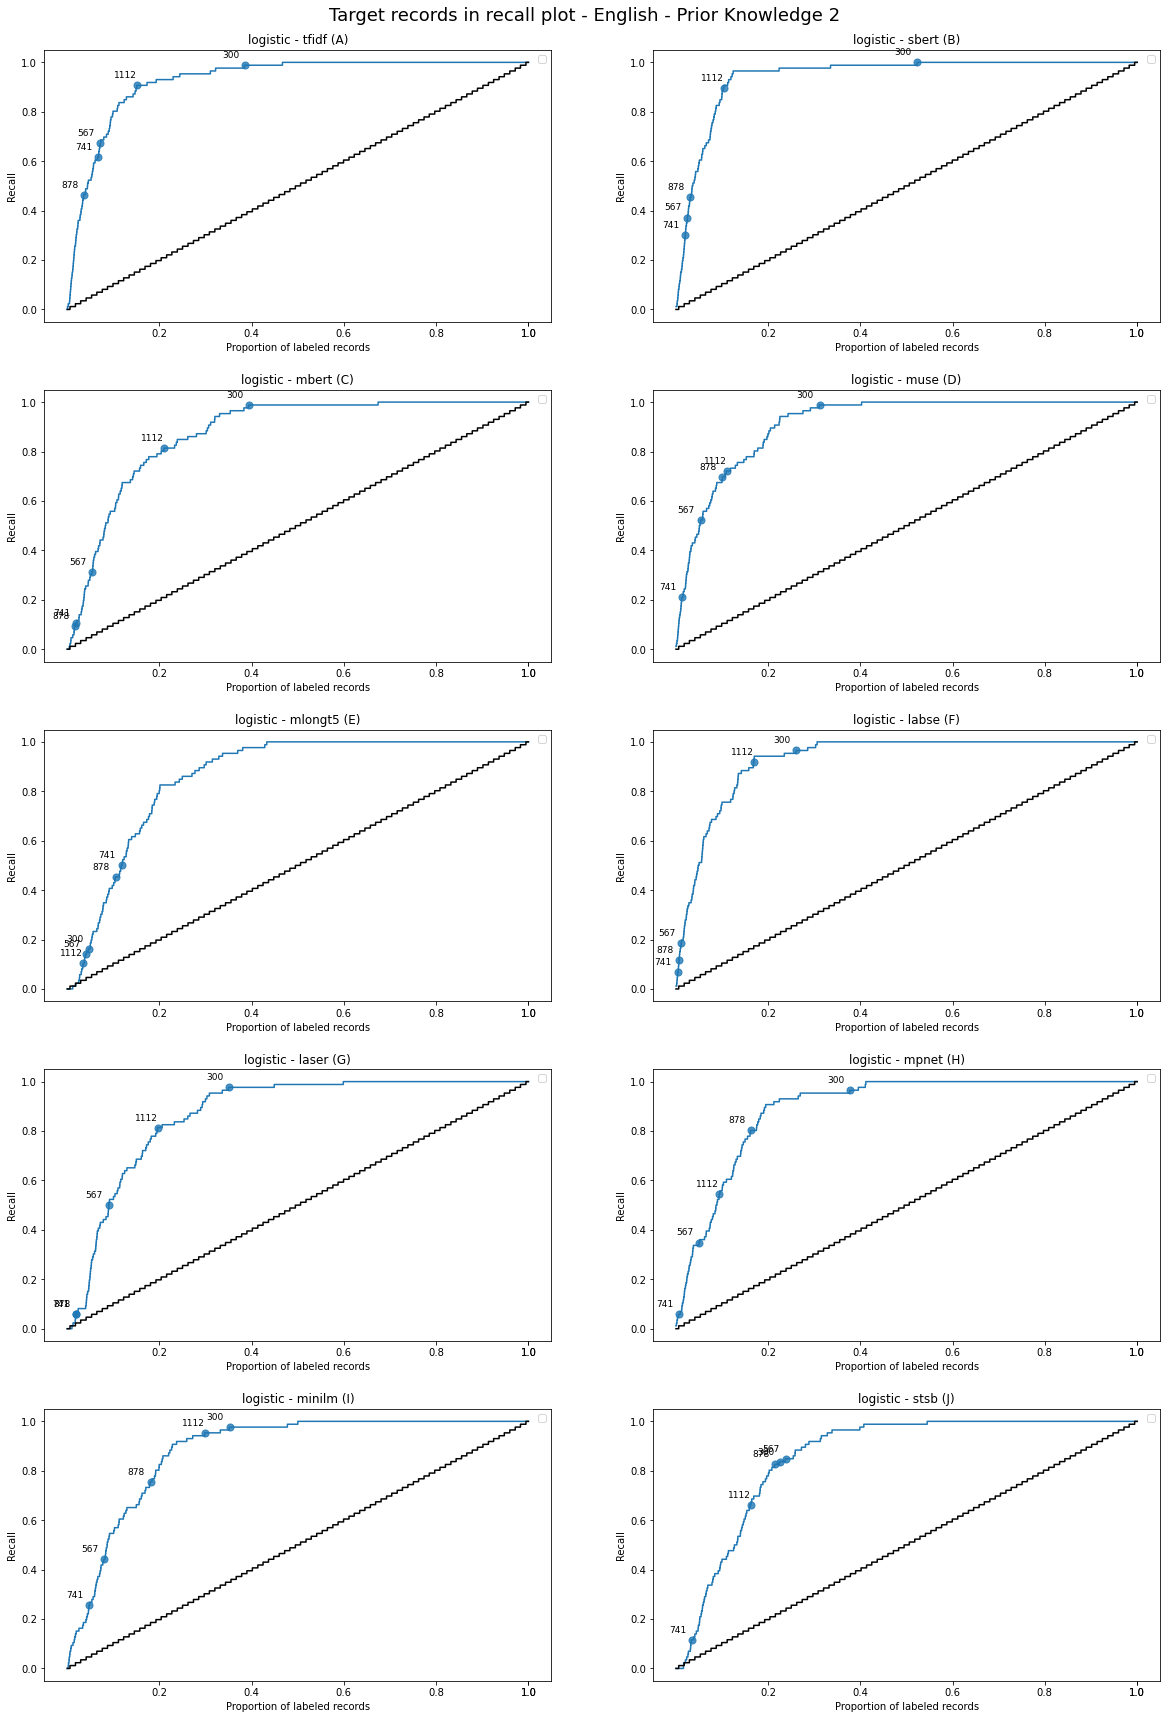

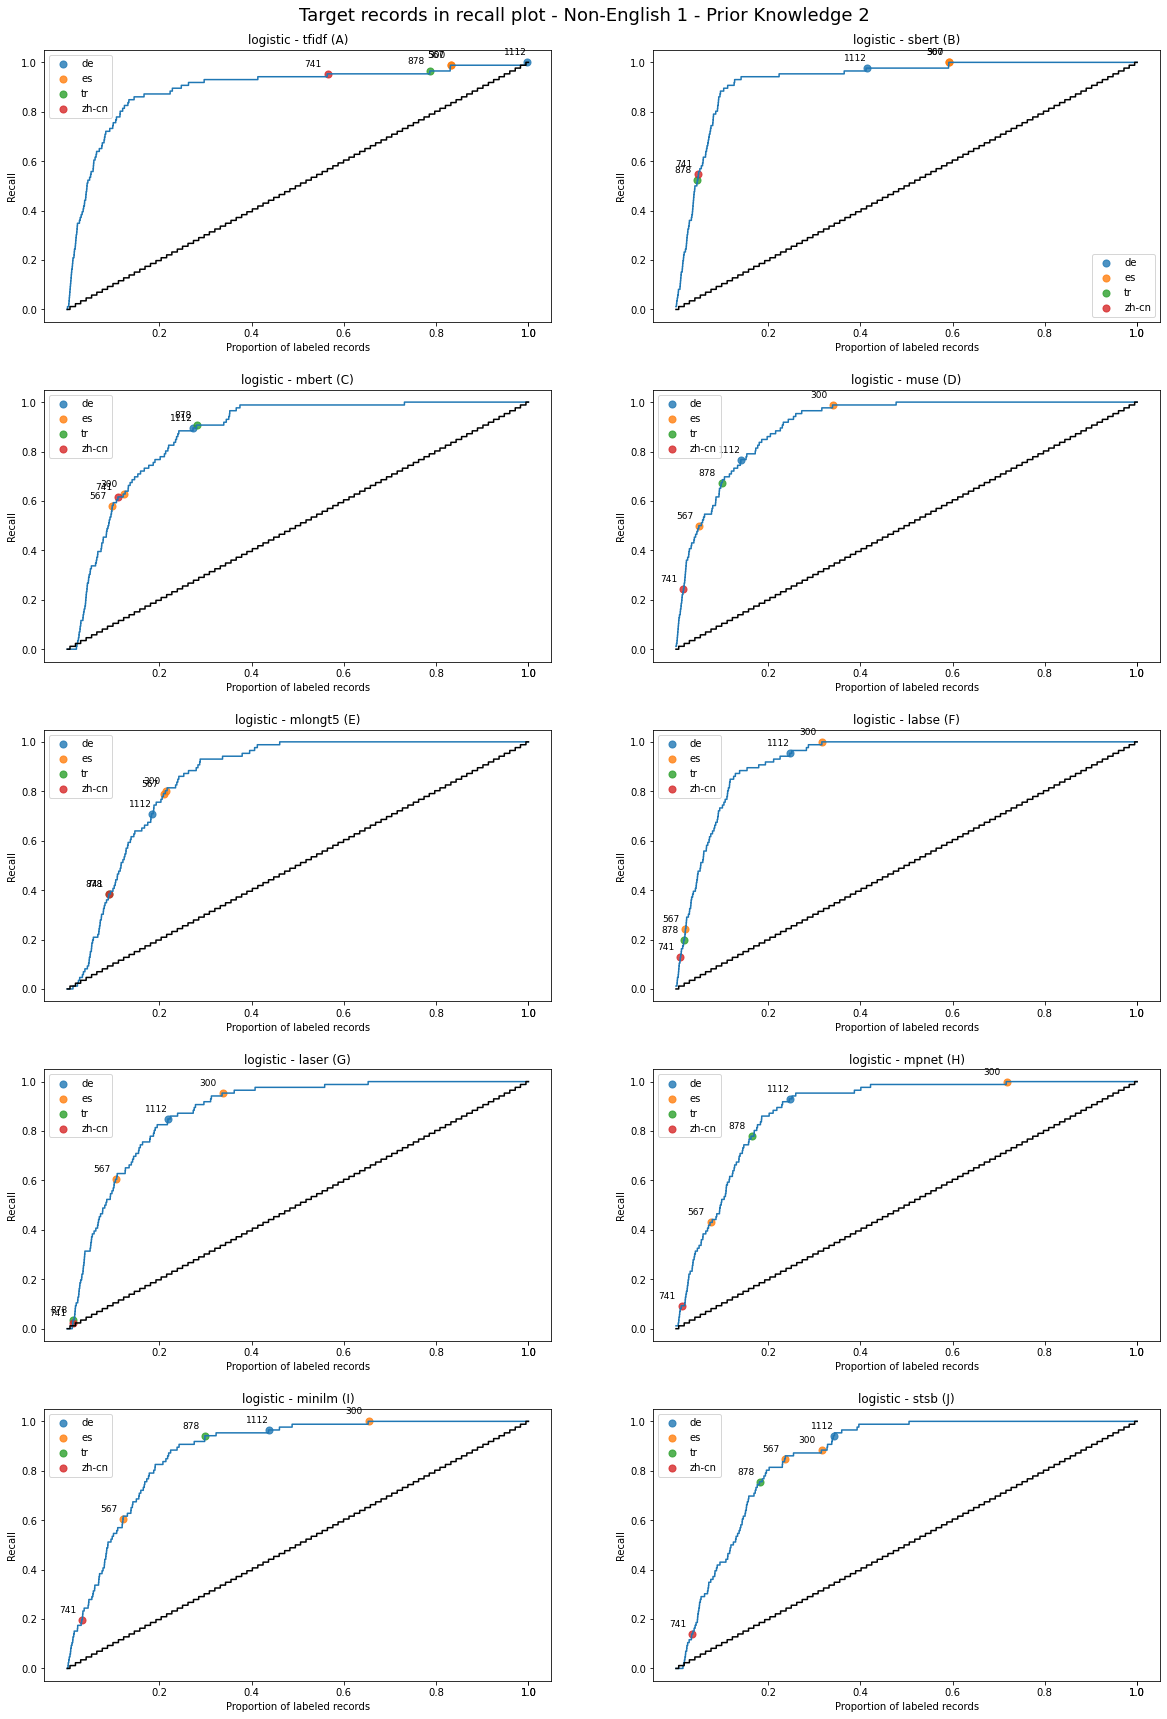

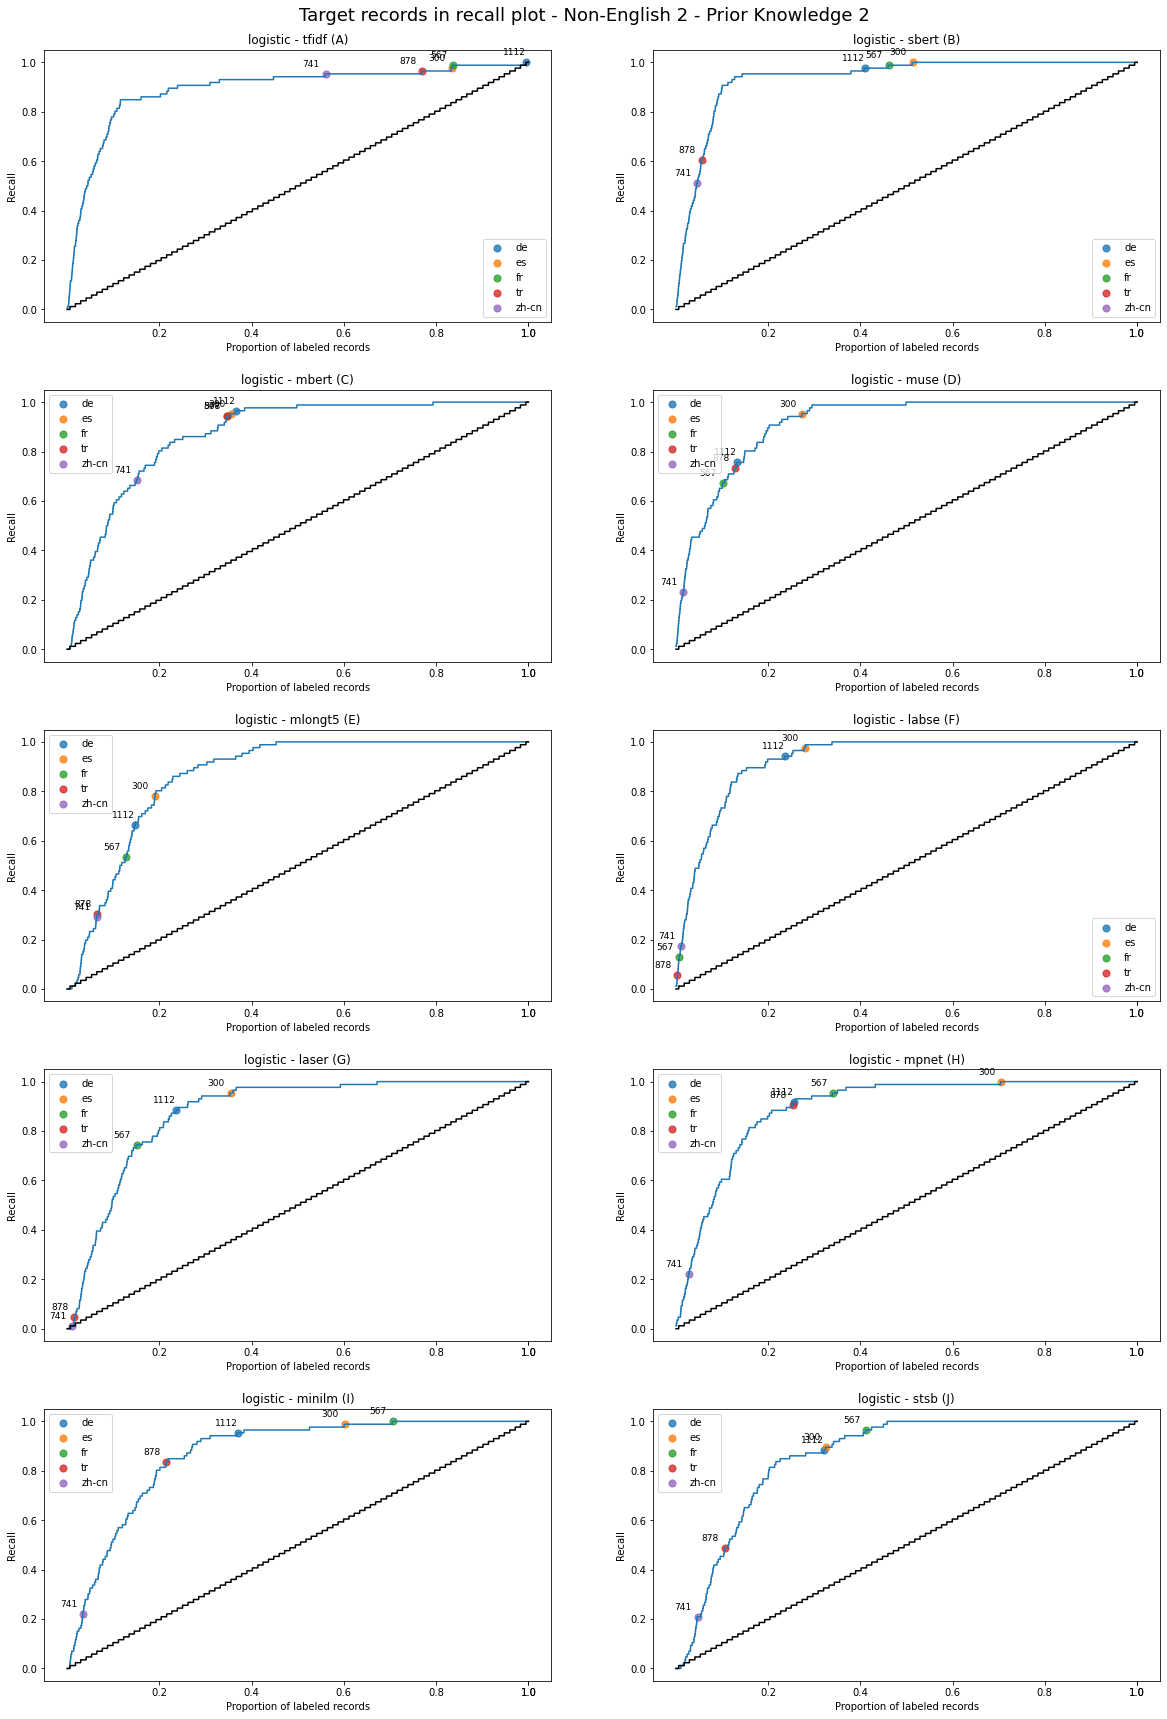

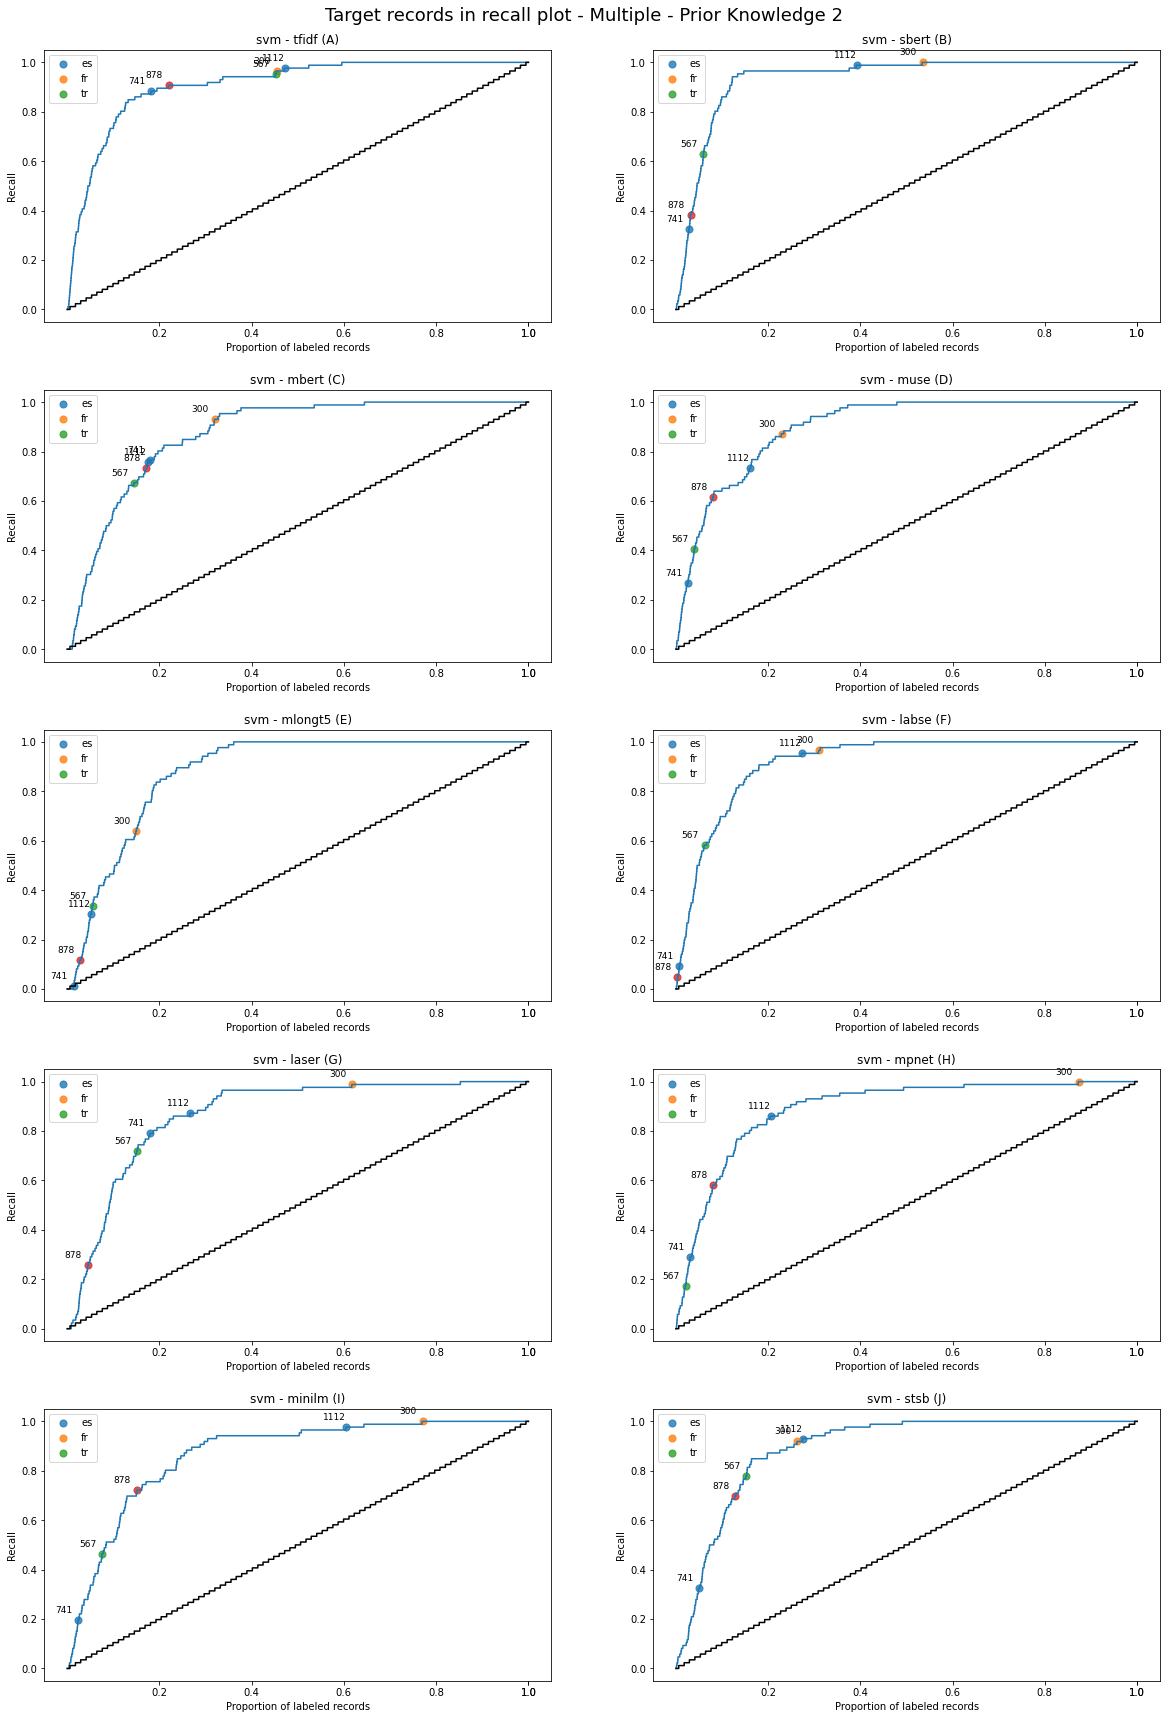

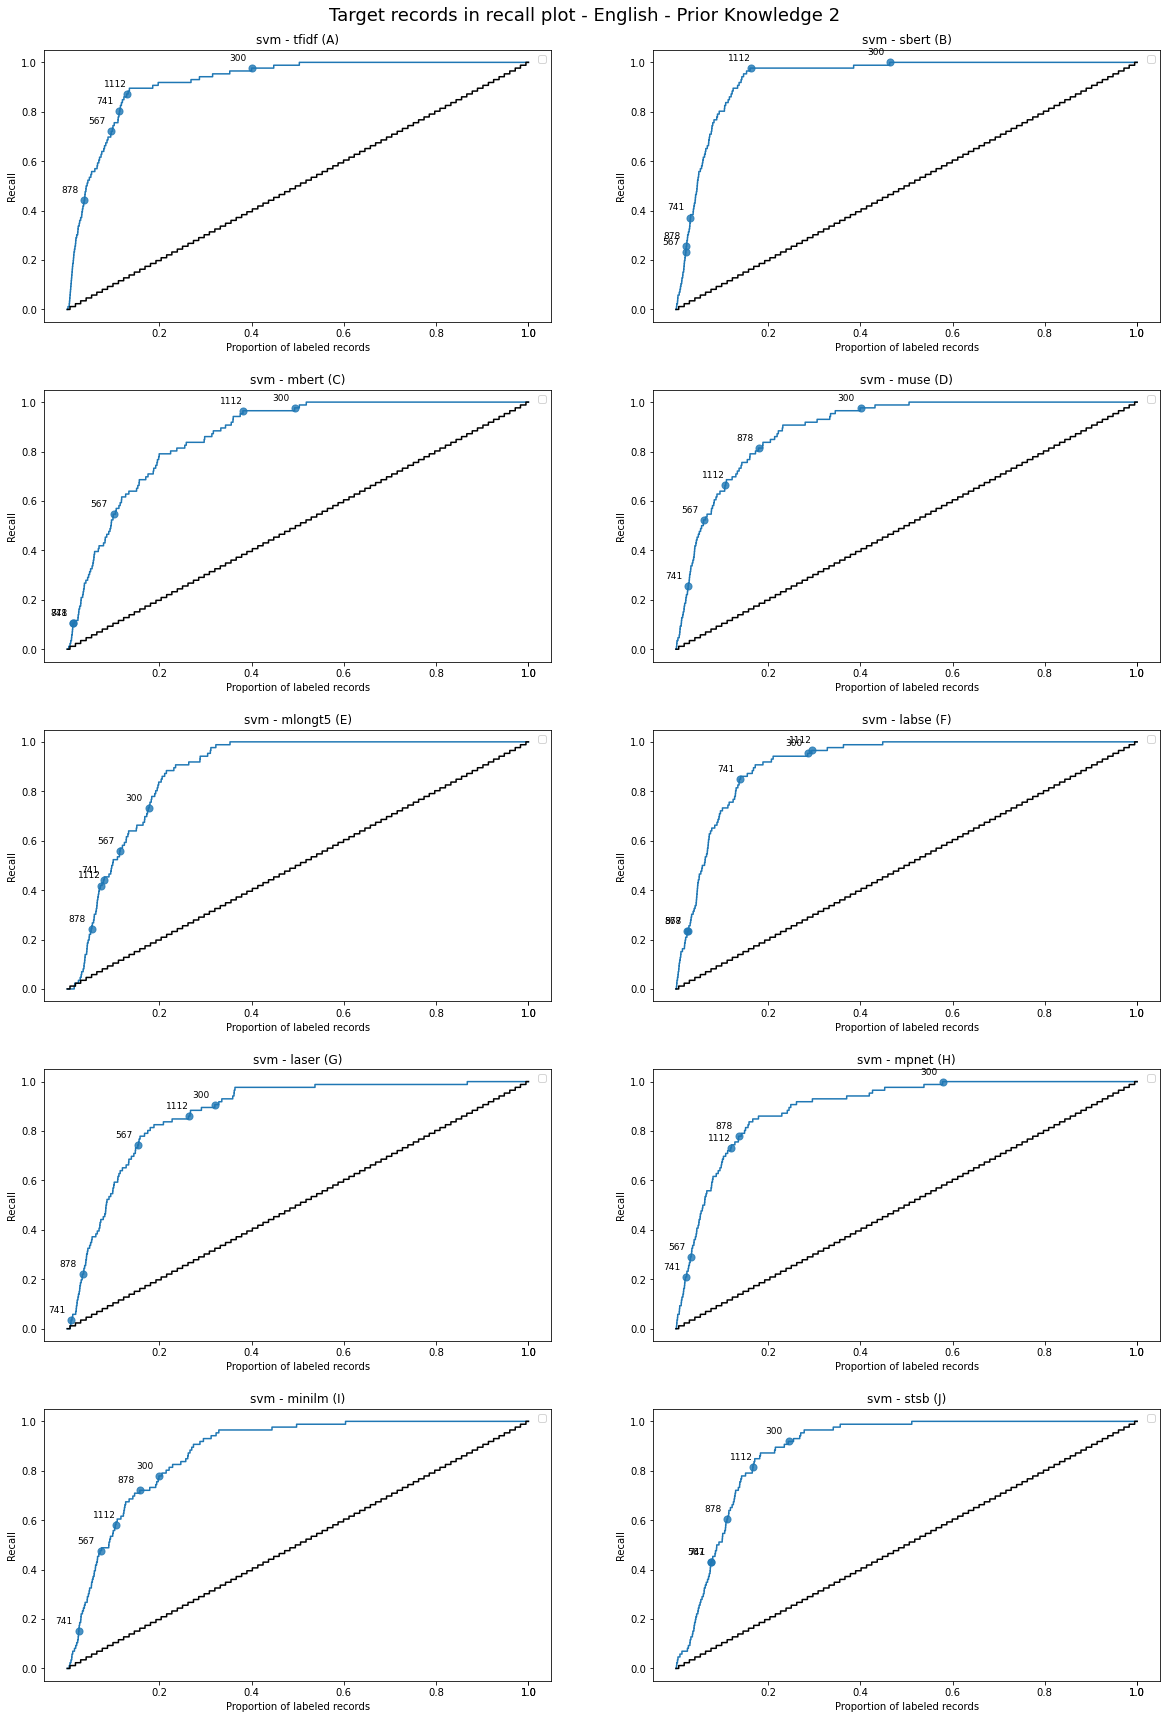

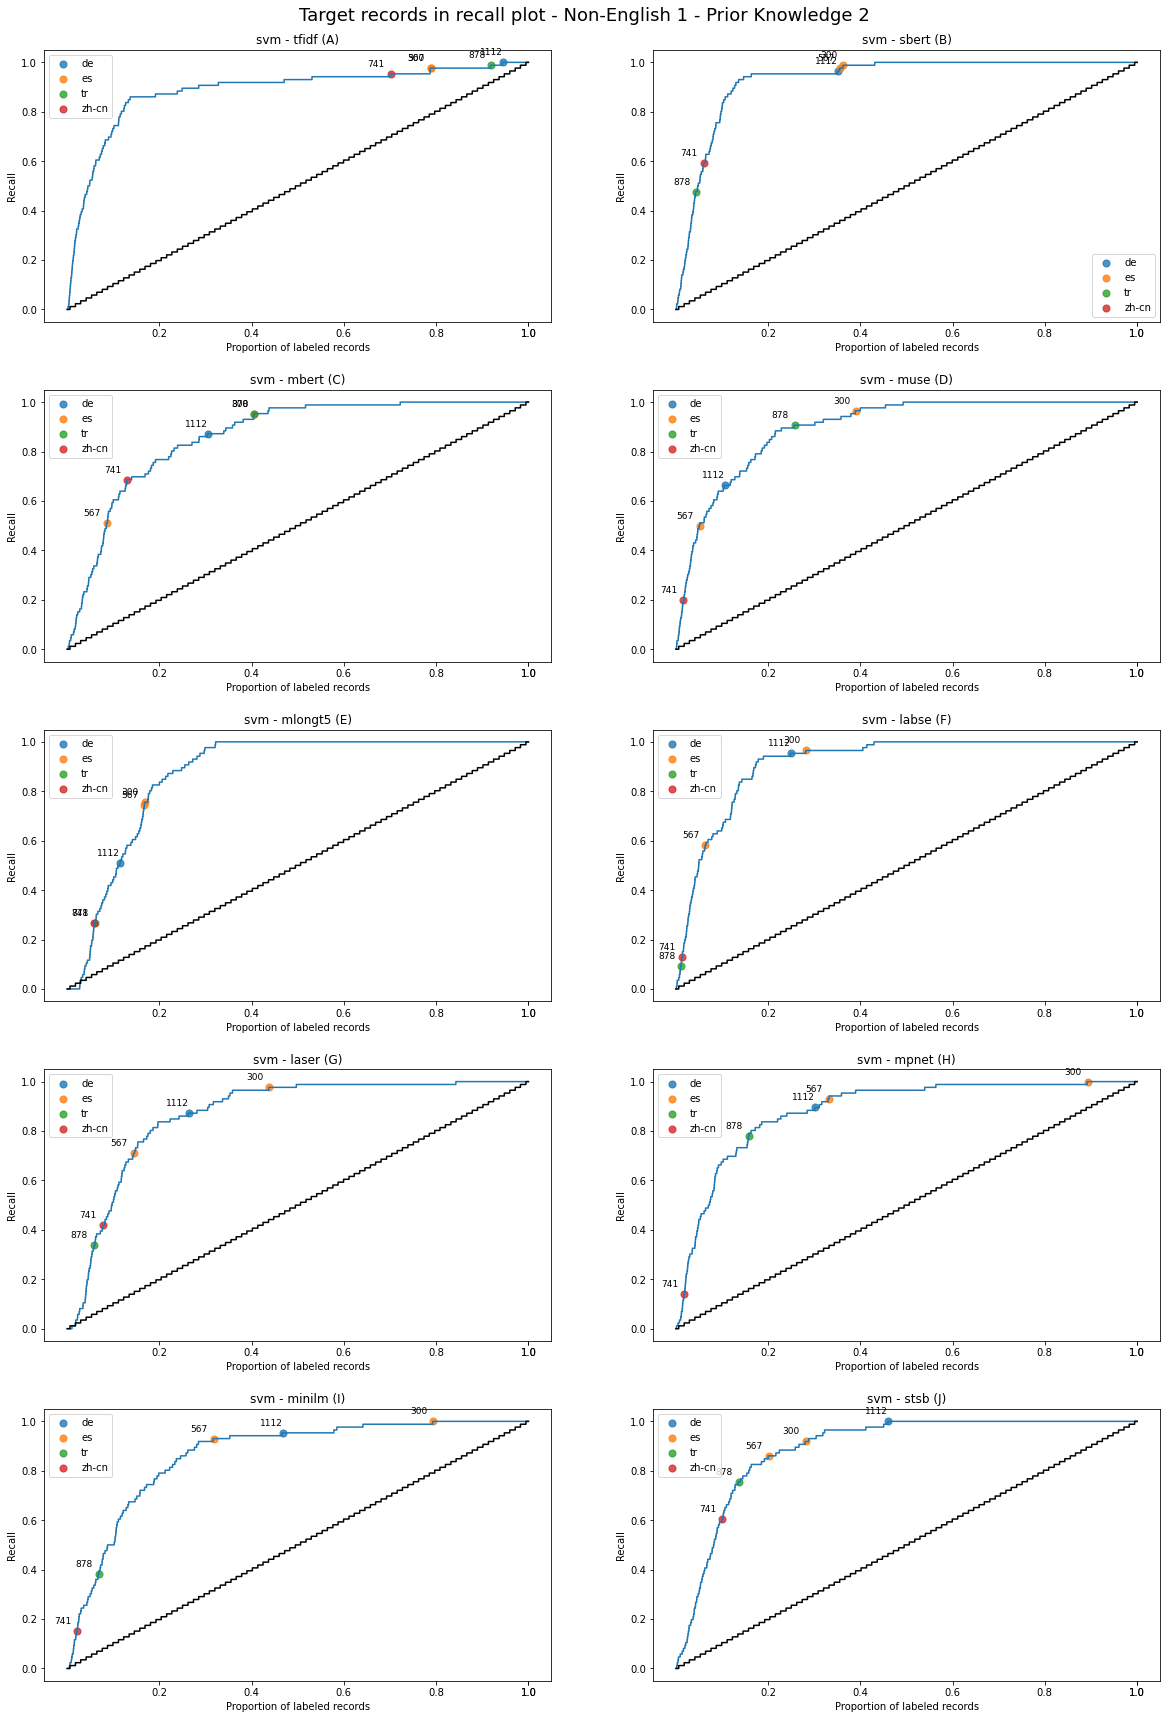

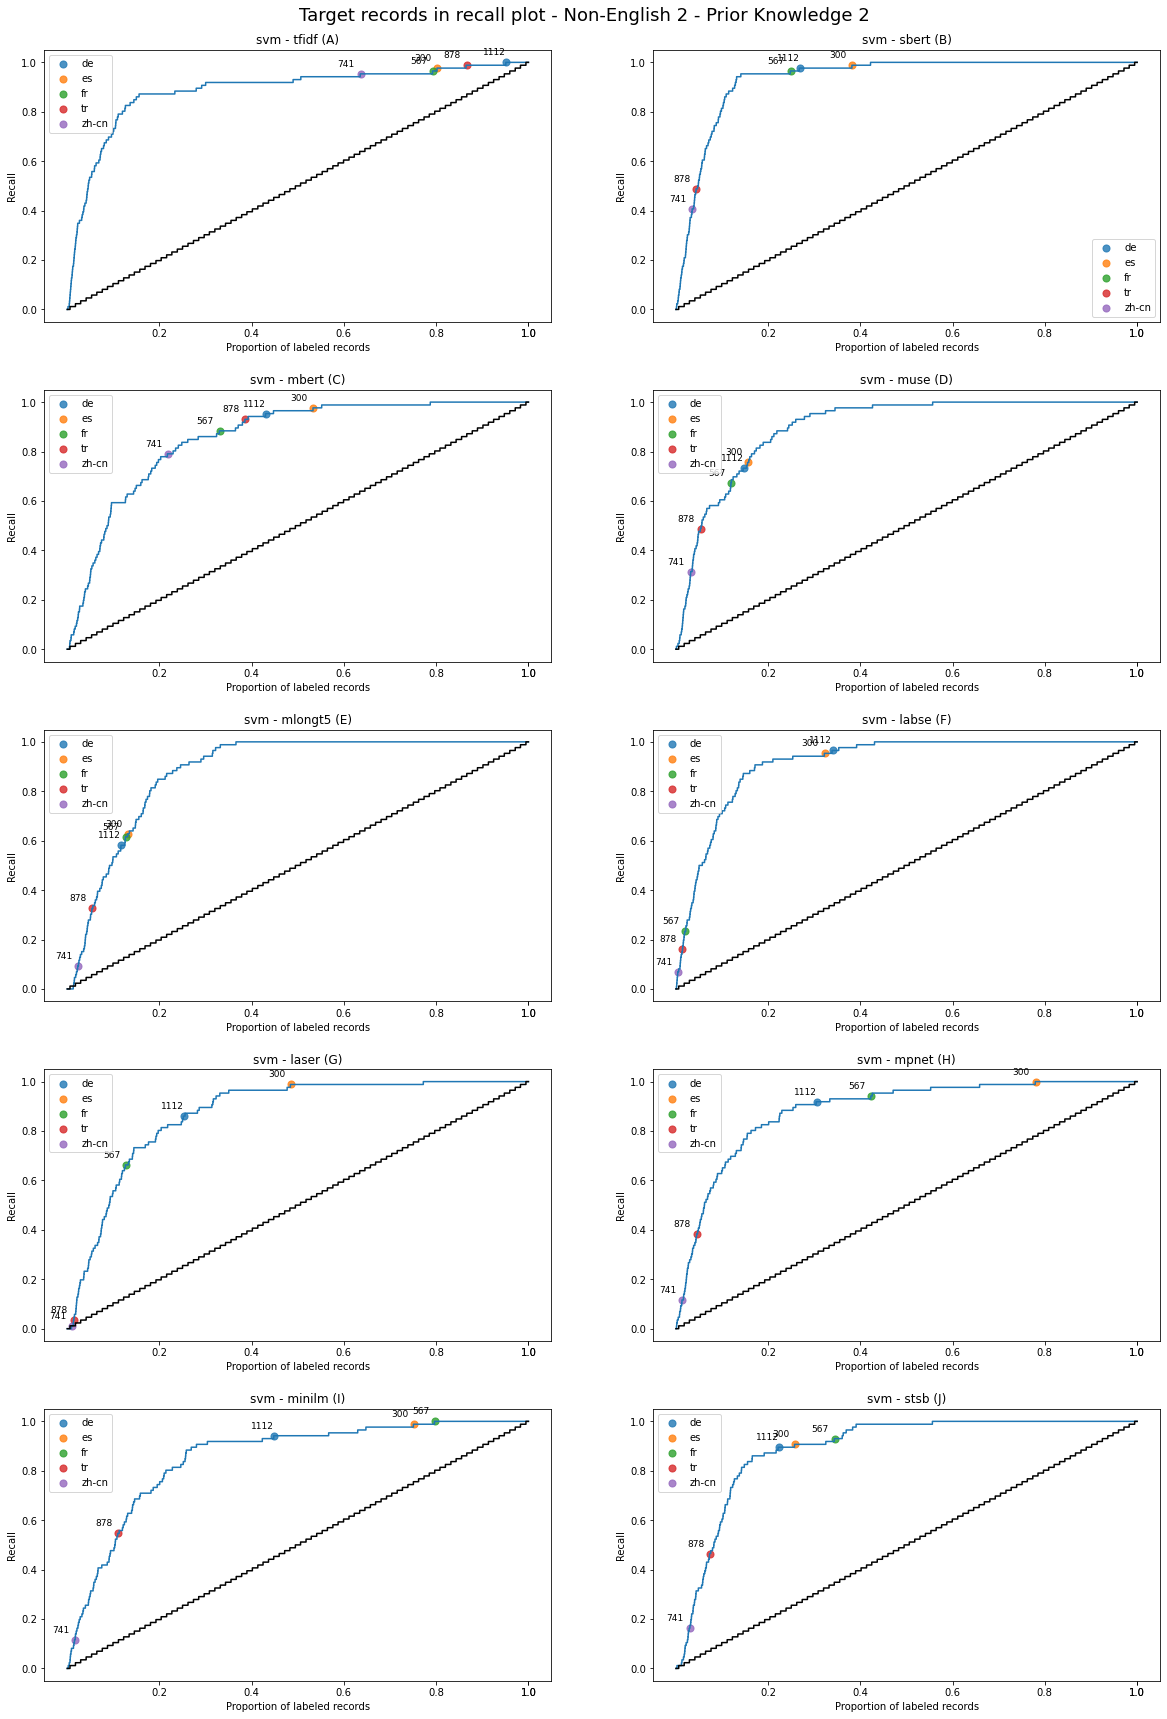

In [22]:
#Create all recall plots
plotCount = 0
for prior in prior_knowledge:
    for classifier in classifiers:
        for dataset in datasets:
            plt.figure(figsize=(20, 30))
            plt.subplots_adjust(hspace=0.25)
            if dataset == 'Original':
                tit = 'Multiple'
            elif dataset == 'Multi_1':
                tit = 'Non-English 1'
            elif dataset == 'Multi_2':
                tit = 'Non-English 2'
            else:
                tit = 'English'
            plt.suptitle("Target records in recall plot - " + tit + ' - Prior Knowledge ' + prior, fontsize=18, y=0.90)
            n = 0
            for model in models:
                ax = plt.subplot(5, 2, n + 1)
                with open_state(state_target.format(prior, dataset, classifier, model)) as state:
                    states_df = state.get_dataset()

                    sim_labels = pad_simulation_labels(state)
                    x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)

                    languages = language_dfs[dataset]
                    states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
                    non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False)
                                                & (states_df.label == 1))]
                    targets = states_df.loc[states_df.record_id.isin([300, 567, 741, 878, 1112])]

                    for language in targets.language.sort_values().unique():
                        temp = targets.loc[targets.language == language]
                        ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", s=50,
                                   alpha=0.8)
                        for index, row in temp.iterrows():
                            ax.text(x[index] - 0.05, y[index] + 0.03, row.record_id, fontsize=9)
                    ax.legend(non_english.language.sort_values().unique())

                    # draw the plot
                    plot_recall(ax, state)

                    ax.set_title(classifier + ' - ' + model + ' (' + string.ascii_uppercase[n] + ')')
                    n += 1
            plotCount += 1
            #plt.savefig('Recall plot ' + str(plotCount) +'.png')

## ATD Plots

<ipython-input-23-9fd15655f90c>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = metrics_df.groupby('Dataset')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


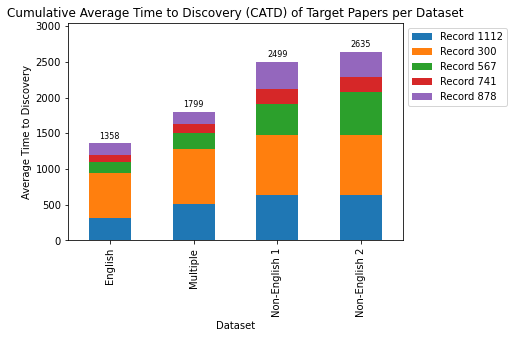

In [23]:
# ATD's of target papers per dataset
# Define the mapping dictionary for dataset renaming
dataset_mapping = {
    'Original': 'Multiple',
    'Multi_1': 'Non-English 1',
    'Multi_2': 'Non-English 2'
}

# Group by the desired factor and calculate the mean of 'td' values
grouped_df = metrics_df.groupby('Dataset')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

# Sort the grouped DataFrame by the average 'td' values in ascending order
grouped_df = grouped_df.reindex(grouped_df.mean(axis=1).sort_values().index)

# Set the factor you want to group by (e.g., 'Dataset', 'Prior Knowledge', 'Classifier')
group_by_factor = 'Dataset'

# Create the stacked bar chart
ax = grouped_df.plot.bar(stacked=True)

# Set the x-axis label
plt.xlabel(group_by_factor)

# Set the y-axis label
plt.ylabel('Average Time to Discovery')

# Modify the legend labels
legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']
ax.legend(labels=legend_labels, bbox_to_anchor=(1, 1))

# Rename the datasets on the x-axis
new_labels = [dataset_mapping.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)

# Set the title for the plot
plt.title("Cumulative Average Time to Discovery (CATD) of Target Papers per Dataset")

# Add the sum of the entire bar on top
for i, value in enumerate(grouped_df.values):
    x = i
    y = value.sum()
    
    # Annotate the rounded sum value at the top of each bar
    ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', fontsize=8, color='black')

# Adjust the y-axis limits
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

# Show the plot
plt.show()

<ipython-input-24-a050705710ed>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = metrics_df.groupby(['Dataset', group])['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


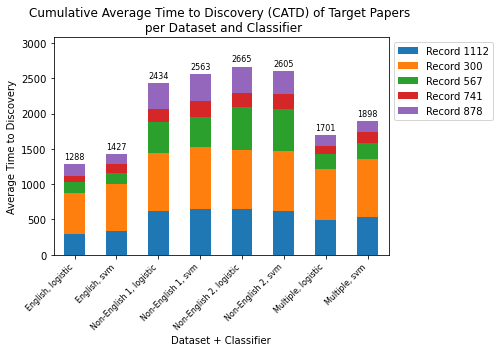

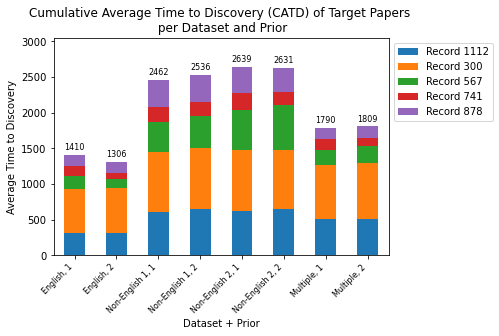

In [24]:
# Define the mapping dictionary for dataset renaming
dataset_mapping = {
    'Original': 'Multiple',
    'Multi_1': 'Non-English 1',
    'Multi_2': 'Non-English 2'
}

groups = ['Classifier', 'Prior']

for group in groups:
    # Group by the desired factor and calculate the mean of 'td' values
    grouped_df = metrics_df.groupby(['Dataset', group])['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

    # Set the factor you want to group by (e.g., 'Dataset', 'Prior Knowledge', 'Classifier')
    group_by_factor = 'Dataset'

    # Create the stacked bar chart
    ax = grouped_df.plot.bar(stacked=True)

    # Set the x-axis label
    plt.xlabel(group_by_factor + ' + ' + group)

    # Set the y-axis label
    plt.ylabel('Average Time to Discovery')

    # Modify the legend labels
    legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']
    ax.legend(labels=legend_labels, bbox_to_anchor=(1, 1))

    # Update the dataset labels on the x-axis to include prior knowledge
    x_pos = range(len(grouped_df))
    xticklabels = [
        f"{dataset_mapping.get(dataset, dataset)}, {prior.split('_')[-1]}"
        for (dataset, prior), i in zip(grouped_df.index, x_pos)
    ]
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)

    # Set the title for the plot
    plt.title("Cumulative Average Time to Discovery (CATD) of Target Papers \n per Dataset and " + group)

    # Add the sum of the entire bar on top
    for i, value in enumerate(grouped_df.values):
        x = i
        y = value.sum()

        # Annotate the rounded sum value at the top of each bar
        ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8, color='black')

    # Adjust the y-axis limits
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

    # Show the plot
    plt.show()

<ipython-input-25-084a8412c883>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df.groupby('Model')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


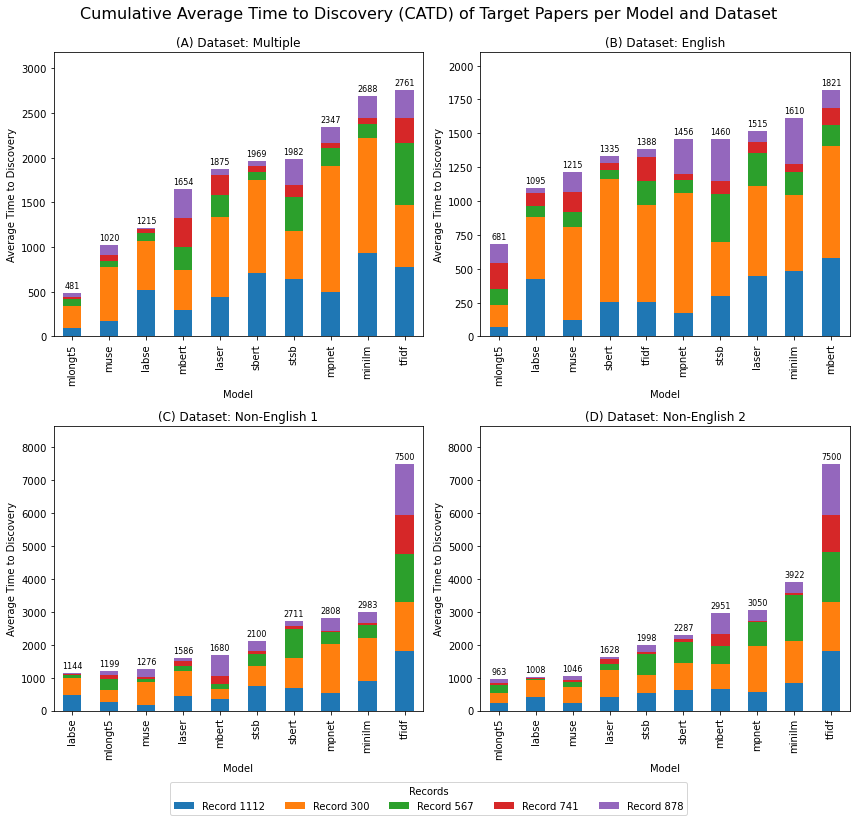

In [25]:
# ATD's per model per dataset
# Create a new figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over each dataset
for i, dataset in enumerate(datasets):
    # Select the data for the current dataset
    df = metrics_df.loc[metrics_df.Dataset == dataset]

    # Group by the desired factor and calculate the mean of 'td' values
    grouped_df = df.groupby('Model')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

    # Sort the grouped DataFrame by the average 'td' values in ascending order (only for 'Model' group)
    grouped_df = grouped_df.reindex(grouped_df.mean(axis=1).sort_values().index)

    # Create the stacked bar chart for the current dataset
    ax = axes[i // 2, i % 2]
    grouped_df.plot.bar(stacked=True, ax=ax)

    # Set the x-axis label
    ax.set_xlabel('Model')

    # Set the y-axis label
    ax.set_ylabel('Average Time to Discovery')

    # Set the title for each plot with labels A, B, C, D
    dataset_title = dataset_mapping.get(dataset, dataset)
    ax.set_title(f"({string.ascii_uppercase[i]}) Dataset: {dataset_title}")

    # Add the sum of the entire bar on top
    for j, value in enumerate(grouped_df.values):
        x = j
        y = value.sum()

        # Annotate the rounded sum value at the top of each bar
        ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8, color='black')

    # Adjust the y-axis limits
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

# Set the title for the figure
fig.suptitle("Cumulative Average Time to Discovery (CATD) of Target Papers per Model and Dataset", fontsize=16)

# Remove legends from subplots
for ax in axes.flatten():
    ax.legend().remove()

# Modify the legend labels
legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']

# Create a common legend underneath the subplots
fig.legend(labels=legend_labels, loc='lower center', title='Records', ncol=5, bbox_to_anchor=(0.5, -0.15))

# Adjust the spacing between subplots and legend
fig.tight_layout(rect=[0, -0.1, 1, 0.99])

# Show the plot
plt.show()